# Análisis de Ventas - Supermarket Sales

## 1. Configuración Inicial

In [51]:
# Librerías
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
import duckdb

In [52]:
# Configuración visual
#plt.style.use('seaborn')

## 2. Carga de Datos

In [53]:
# Opción 1: Desde pandas
df = pd.read_csv('../data/supermarket_sales.csv')

In [54]:
# Opción 2: Desde DuckDB
con = duckdb.connect()  # Conexión en memoria

### preparacion

In [55]:
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,Cost of goods sold,Gross margin percentage,Gross income,Customer stratification rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [56]:
# Cuando el CSV es grande (>100MB)
query = """
SELECT * 
-- FROM df
FROM '../data/supermarket_sales.csv'
LIMIT 5
"""
resultado = con.execute(query).fetchdf()
resultado

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,Cost of goods sold,Gross margin percentage,Gross income,Customer stratification rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08:00,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29:00,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23:00,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33:00,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37:00,Ewallet,604.17,4.761905,30.2085,5.3


In [57]:
df.columns

Index(['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender',
       'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Total', 'Date',
       'Time', 'Payment', 'Cost of goods sold', 'Gross margin percentage',
       'Gross income', 'Customer stratification rating'],
      dtype='object')

In [58]:
news_columns = {
    'Invoice ID': 'invoice_id',
    'Branch': 'branch',
    'City': 'city',
    'Customer type': 'customer_type',
    'Gender': 'gender',
    'Product line': 'product_line',
    'Unit price': 'unit_price',
    'Quantity': 'quantity',
    'Tax 5%': 'tax_5_percent',
    'Total': 'total',
    'Date': 'date',
    'Time': 'time',
    'Payment': 'payment_method',
    'Cost of goods sold': 'cost_of_goods_sold',
    'Gross margin percentage': 'gross_margin_percentage',
    'Gross income': 'gross_income',
    'Customer stratification rating': 'customer_rating'
}
#df = df.rename(columns=news_columns)

In [59]:
# Convertir a datetime
df['datetime'] = pd.to_datetime(
    df['Date'] + ' ' + df['Time'],  # Combina "1/5/2019 13:08"
    format='%m/%d/%Y %H:%M'        # Define el formato de entrada
)

print(df['datetime'])

0     2019-01-05 13:08:00
1     2019-03-08 10:29:00
2     2019-03-03 13:23:00
3     2019-01-27 20:33:00
4     2019-02-08 10:37:00
              ...        
995   2019-01-29 13:46:00
996   2019-03-02 17:16:00
997   2019-02-09 13:22:00
998   2019-02-22 15:33:00
999   2019-02-18 13:28:00
Name: datetime, Length: 1000, dtype: datetime64[ns]


In [60]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M').dt.time
df['Time']

0      13:08:00
1      10:29:00
2      13:23:00
3      20:33:00
4      10:37:00
         ...   
995    13:46:00
996    17:16:00
997    13:22:00
998    15:33:00
999    13:28:00
Name: Time, Length: 1000, dtype: object

## 3. Análisis Exploratorio (EDA+)

In [61]:
df.describe()

,Unit price,Quantity,Tax 5%,Total,Date,Cost of goods sold,Gross margin percentage,Gross income,Customer stratification rating,datetime
count,1000.000000,1000.000000,1000.000000,1000.000000,1000,1000.00000,1000.000000,1000.000000,1000.00000,1000
mean,55.672130,5.510000,15.379369,322.966749,2019-02-14 00:05:45.600000,307.58738,4.761905,15.379369,6.97270,2019-02-14 15:30:27.480000
min,10.080000,1.000000,0.508500,10.678500,2019-01-01 00:00:00,10.17000,4.761905,0.508500,4.00000,2019-01-01 10:39:00
25%,32.875000,3.000000,5.924875,124.422375,2019-01-24 00:00:00,118.49750,4.761905,5.924875,5.50000,2019-01-24 17:58:45
50%,55.230000,5.000000,12.088000,253.848000,2019-02-13 00:00:00,241.76000,4.761905,12.088000,7.00000,2019-02-13 17:37:00
75%,77.935000,8.000000,22.445250,471.350250,2019-03-08 00:00:00,448.90500,4.761905,22.445250,8.50000,2019-03-08 15:29:30
max,99.960000,10.000000,49.650000,1042.650000,2019-03-30 00:00:00,993.00000,4.761905,49.650000,10.00000,2019-03-30 20:37:00
std,26.494628,2.923431,11.708825,245.885335,NaN,234.17651,0.000000,11.708825,1.71858,NaN


In [62]:
# Métricas basicas
print("Ventas Totales", f"${df['Total'].sum():,.2f}")
print("Transacciones", f"{len(df):,}")
print("Venta Promedio", f"${df['Total'].mean():,.2f}")
print("Margen Bruto Promedio", f"${df['Gross income'].mean():,.2f}")

Ventas Totales $322,966.75
Transacciones 1,000
Venta Promedio $322.97
Margen Bruto Promedio $15.38


In [63]:
# Métricas Básicas de Ventas
print("\n" + "="*50)
print("📊 MÉTRICAS CLAVE DE VENTAS".center(50))
print("="*50)
print(f"💰 Ventas Totales: ${df['Total'].sum():,.2f}")
print(f"🛒 Transacciones Totales: {len(df):,}")
print(f"📦 Unidades Vendidas: {df['Quantity'].sum():,}")
print(f"🏷️ Ticket Promedio: ${df['Total'].mean():,.2f}")
print(f"📈 Venta Máxima: ${df['Total'].max():,.2f} (ID: {df.loc[df['Total'].idxmax(), 'Invoice ID']})")

# Métricas de Rentabilidad
print("\n" + "="*50)
print("💵 MÉTRICAS DE RENTABILIDAD".center(50))
print("="*50)
print(f"📉 Costo de Ventas: ${df['Cost of goods sold'].sum():,.2f}")
print(f"🔼 Margen Bruto Total: ${df['Gross income'].sum():,.2f}")
print(f"📊 Margen Bruto %: {df['Gross income'].sum()/df['Total'].sum()*100:.2f}%")
print(f"📌 Margen Promedio por Transacción: ${df['Gross income'].mean():,.2f}")

# Métricas Temporales
print("\n" + "="*50)
print("⏳ MÉTRICAS TEMPORALES".center(50))
print("="*50)
date_range = df['datetime'].max() - df['datetime'].min()
print(f"🕰️ Período Analizado: {df['datetime'].min().strftime('%d/%m/%Y')} - {df['datetime'].max().strftime('%d/%m/%Y')} ({date_range.days} días)")
print(f"⏱️ Transacciones/Día: {len(df)/date_range.days:,.1f}")
print(f"🕒 Hora Pico: {df['datetime'].dt.hour.mode()[0]}:00 - {df['datetime'].dt.hour.mode()[0]+1}:00")

# Métricas por Sucursal
print("\n" + "="*50)
print("🏪 DESEMPEÑO POR SUCURSAL".center(50))
print("="*50)
branch_stats = df.groupby('Branch').agg({
    'Total': ['sum', 'mean', 'count'],
    'Gross income': 'mean'
})
branch_stats.columns = ['Ventas Totales', 'Ticket Promedio', 'Transacciones', 'Margen Promedio']
print(branch_stats.sort_values('Ventas Totales', ascending=False).to_string(formatters={
    'Ventas Totales': '${:,.2f}'.format,
    'Ticket Promedio': '${:,.2f}'.format,
    'Margen Promedio': '${:,.2f}'.format
}))

# Métricas por Línea de Producto
print("\n" + "="*50)
print("🛍️ DESEMPEÑO POR CATEGORÍA".center(50))
print("="*50)
product_stats = df.groupby('Product line').agg({
    'Total': ['sum', 'mean'],
    'Quantity': 'sum',
    'Gross income': 'sum'
})
product_stats.columns = ['Ventas Totales', 'Ticket Promedio', 'Unidades', 'Margen Bruto']
print(product_stats.sort_values('Ventas Totales', ascending=False).to_string(formatters={
    'Ventas Totales': '${:,.2f}'.format,
    'Ticket Promedio': '${:,.2f}'.format,
    'Margen Bruto': '${:,.2f}'.format
}))

# Eficiencia Operativa
print("\n" + "="*50)
print("⚙️ EFICIENCIA OPERATIVA".center(50))
print("="*50)
payment_stats = df['Payment'].value_counts(normalize=True)*100
print("💳 Mix de Métodos de Pago:")
print(payment_stats.round(1).astype(str) + '%')
print(f"\n👥 Mix de Clientes: Miembros {df['Customer type'].value_counts(normalize=True)['Member']*100:.1f}%")


            📊 MÉTRICAS CLAVE DE VENTAS            
💰 Ventas Totales: $322,966.75
🛒 Transacciones Totales: 1,000
📦 Unidades Vendidas: 5,510
🏷️ Ticket Promedio: $322.97
📈 Venta Máxima: $1,042.65 (ID: 860-79-0874)

            💵 MÉTRICAS DE RENTABILIDAD            
📉 Costo de Ventas: $307,587.38
🔼 Margen Bruto Total: $15,379.37
📊 Margen Bruto %: 4.76%
📌 Margen Promedio por Transacción: $15.38

              ⏳ MÉTRICAS TEMPORALES               
🕰️ Período Analizado: 01/01/2019 - 30/03/2019 (88 días)
⏱️ Transacciones/Día: 11.4
🕒 Hora Pico: 19:00 - 20:00

             🏪 DESEMPEÑO POR SUCURSAL             
       Ventas Totales Ticket Promedio  Transacciones Margen Promedio
Branch                                                              
C         $110,568.71         $337.10            328          $16.05
A         $106,200.37         $312.35            340          $14.87
B         $106,197.67         $319.87            332          $15.23

            🛍️ DESEMPEÑO POR CATEGORÍA        

In [64]:
query = """
SELECT 
    Branch AS Sucursal,
    "Product line" AS Linea_Producto,
    SUM(Total) AS Ventas_Totales,
    AVG("Unit price") AS Precio_Promedio,
    SUM(Quantity) AS Unidades_Vendidas
FROM df
GROUP BY Branch, "Product line"
ORDER BY Ventas_Totales DESC
"""
resultado = con.execute(query).fetchdf()
resultado

,Sucursal,Linea_Producto,Ventas_Totales,Precio_Promedio,Unidades_Vendidas
0,C,Food and beverages,23766.8550,57.273030,369.0
1,A,Home and lifestyle,22417.1955,55.845692,371.0
2,C,Fashion accessories,21560.0700,59.736000,342.0
3,B,Sports and travel,19988.1990,59.678065,322.0
4,B,Health and beauty,19980.6600,58.185660,320.0
5,A,Sports and travel,19372.6995,55.610339,333.0
6,C,Electronic accessories,18968.9745,55.809455,333.0
7,A,Electronic accessories,18317.1135,54.871167,322.0
8,B,Home and lifestyle,17549.1645,55.514000,295.0
9,A,Food and beverages,17163.1005,54.974483,313.0


In [65]:
query = """
SELECT 
    Branch,
    strftime(Date, '%Y-%m') AS Mes,
    SUM(Total) AS Ventas_Mes,
    (SUM(Total) - LAG(SUM(Total), 1) OVER (PARTITION BY Branch ORDER BY strftime(Date, '%Y-%m'))) / 
    LAG(SUM(Total), 1) OVER (PARTITION BY Branch ORDER BY strftime(Date, '%Y-%m')) * 100 AS Crecimiento_Porcentual
FROM df
GROUP BY Branch, Mes
ORDER BY Branch, Mes
"""

resultado = con.execute(query).fetchdf()
resultado

,Branch,Mes,Ventas_Mes,Crecimiento_Porcentual
0,A,2019-01,38681.1285,NaN
1,A,2019-02,29860.1205,-22.804423
2,A,2019-03,37659.1215,26.118451
3,B,2019-01,37176.0585,NaN
4,B,2019-02,34424.2710,-7.402042
5,B,2019-03,34597.3425,0.502760
6,C,2019-01,40434.6810,NaN
7,C,2019-02,32934.9825,-18.547688
8,C,2019-03,37199.0430,12.946904


In [66]:
query = """
SELECT 
    "Invoice ID",
    Branch,
    City AS Ciudad,
    "Product line" AS Linea_Producto,
    Total
FROM df
WHERE 
    --Branch = 'A' AND 
    "Product line" IN ('Electronic accessories', 'Food and beverages') AND
    Total > 900
"""
resultado = con.execute(query).fetchdf()
resultado

,Invoice ID,Branch,Ciudad,Linea_Producto,Total
0,704-48-3927,A,Yangon,Electronic accessories,931.0350
1,817-69-8206,B,Mandalay,Electronic accessories,942.4485
2,393-65-2792,C,Naypyitaw,Food and beverages,939.5400
3,283-26-5248,C,Naypyitaw,Food and beverages,1034.4600
4,866-99-7614,C,Naypyitaw,Food and beverages,936.6000
5,277-35-5865,C,Naypyitaw,Food and beverages,935.2665
6,641-51-2661,C,Naypyitaw,Food and beverages,914.5500
7,384-59-6655,A,Yangon,Food and beverages,932.3370


In [67]:
kv = con.execute("""
    COPY (
        SELECT * FROM df
        WHERE strftime(Date, '%Y-%m') = '2019-02'
    ) 
    TO 'ventas_enero_2019.parquet' (FORMAT PARQUET)
""").fetchdf()

In [68]:
# Suponiendo que 'df' es tu DataFrame y ya tiene 'datetime' en formato correcto
ventas_diarias = df.groupby('Date')['Total'].sum().reset_index()

# ventas_diarias = con.execute("""
# SELECT Date, SUM(Total) as Total
# FROM df
# GROUP BY Date
# ORDER BY Date
# """).fetchdf()

In [69]:
# Crear el gráfico de línea
fig_ventas_diarias = px.line(
    ventas_diarias, 
    x='Date', 
    y='Total', 
    title='Ventas Diarias',
    labels={'Total': 'Ventas Totales (USD)', 'Date': 'Fecha'},  # Personalizar etiquetas
    template='plotly_white'  # Estilo moderno
)

# Ordenar fechas (por si acaso)
fig_ventas_diarias.update_xaxes(type='category')  # Para evitar orden automático incorrecto

# Mostrar el gráfico
fig_ventas_diarias.show()

In [70]:
# Ventas por Tipo de Cliente y Género
ventas_tipo_genero = df.groupby(['Customer type', 'Gender'])['Total'].sum().unstack()
# ventas_tipo_genero = con.execute("""
# SELECT 
#     "Customer type",
#     SUM(CASE WHEN Gender = 'Male' THEN Total ELSE 0 END) as Male,
#     SUM(CASE WHEN Gender = 'Female' THEN Total ELSE 0 END) as Female
# FROM df
# GROUP BY "Customer type"
# """).fetchdf()
ventas_tipo_genero

Gender,Female,Male
Customer type,,
Member,88146.9435,76076.5005
Normal,79735.9815,79007.3235


In [71]:
fig_tipo_genero = px.bar(ventas_tipo_genero, title='Ventas por Tipo de Cliente y Género', barmode='group')
fig_tipo_genero.show()

In [72]:
# Ventas por Ciudad
ventas_ciudad = df.groupby('City')['Total'].sum().sort_values(ascending=True)
# ventas_ciudad = con.execute("""
# SELECT City, SUM(Total) as Total
# FROM df
# GROUP BY City
# ORDER BY Total ASC
# """).fetchdf()
ventas_ciudad

City
Mandalay     106197.6720
Yangon       106200.3705
Naypyitaw    110568.7065
Name: Total, dtype: float64

In [73]:
fig_ciudad = px.bar(ventas_ciudad, orientation='h', title='Ventas por Ciudad')
fig_ciudad.show()

In [74]:
# Métodos de Pago
metodos_pago = df['Payment'].value_counts()
# metodos_pago = con.execute("""
# SELECT Payment, COUNT(*) as count
# FROM df
# GROUP BY Payment
# ORDER BY count DESC
# """).fetchdf()
metodos_pago

Payment
Ewallet        345
Cash           344
Credit card    311
Name: count, dtype: int64

In [75]:
fig_metodos_pago = px.pie(values=metodos_pago.values, names=metodos_pago.index, title='Métodos de Pago')
# fig_metodos_pago = px.pie(
#     values=metodos_pago['count'],
#     names=metodos_pago['Payment'],
#     title='Métodos de Pago'
# )
fig_metodos_pago.show()

In [76]:
ventas_cantidad = df.groupby('Product line')['Quantity'].sum().sort_values(ascending=False)
# ventas_cantidad = con.execute("""
# SELECT "Product line", SUM(Quantity) as Quantity
# FROM df
# GROUP BY "Product line"
# ORDER BY Quantity DESC
# """).fetchdf()
fig = px.bar(ventas_cantidad, title='Cantidad de Productos Vendidos por Línea de Producto')
fig.show()

In [77]:
fig = px.histogram(df, x="Unit price", nbins=20, title="Distribución de Precios Unitarios")
fig.show()

In [78]:
#df = pd.read_csv('supermarket_sales.csv')
# Consulta correcta para obtener transacciones por sucursal
resultado = con.execute("""
    SELECT Branch, COUNT(*) AS Transacciones
    FROM df
    GROUP BY Branch
""").fetchdf()
print(resultado)

# Crear el gráfico directamente con el DataFrame resultante
fig = px.pie(resultado, 
             values='Transacciones', 
             names='Branch', 
             title='Distribución de transacciones por sucursal')
fig.show()

  Branch  Transacciones
0      A            340
1      C            328
2      B            332


In [79]:
# 1. Consulta SQL para obtener los datos agrupados
query = """
SELECT 
    "Customer type" AS tipo_cliente,
    Gender AS genero,
    SUM(Total) AS ventas_totales,
    COUNT(*) AS cantidad_transacciones
FROM df
GROUP BY "Customer type", Gender
ORDER BY "Customer type", Gender
"""

# 2. Ejecutar consulta y obtener DataFrame
ventas_tipo_genero = con.execute(query).fetchdf()

# 3. Crear el gráfico de barras agrupadas
fig_tipo_genero = px.bar(
    ventas_tipo_genero,
    x='tipo_cliente',
    y='ventas_totales',
    color='genero',
    title='Ventas por Tipo de Cliente y Género',
    labels={
        'tipo_cliente': 'Tipo de Cliente',
        'ventas_totales': 'Ventas Totales (USD)',
        'genero': 'Género'
    },
    barmode='group',
    text_auto=True  # Muestra los valores en las barras
)

# 4. Personalizar diseño
fig_tipo_genero.update_layout(
    yaxis_tickprefix='$',
    yaxis_tickformat=',.0f',
    uniformtext_minsize=8,
    hovermode='x unified'
)

#fig_tipo_genero.write_html("ventas_por_genero.html")

# 5. Mostrar el gráfico
fig_tipo_genero.show()

# Analisis

## 📊 Análisis Segmentados por Dimensiones Clave
### 1. Análisis de Ventas por Hora del Día

- ¿A qué horas hay picos de ventas?

- Relación entre hora y tipo de cliente (Member/Normal) o género.

,hora,ventas_totales,transacciones,ticket_promedio
0,10,"$31,421.48",101,$311.10
1,11,"$30,377.33",90,$337.53
2,12,"$26,065.88",89,$292.88
3,13,"$34,723.23",103,$337.12
4,14,"$30,828.40",83,$371.43
5,15,"$31,179.51",102,$305.68
6,16,"$25,226.32",77,$327.61
7,17,"$24,445.22",74,$330.34
8,18,"$26,030.34",93,$279.90
9,19,"$39,699.51",113,$351.32


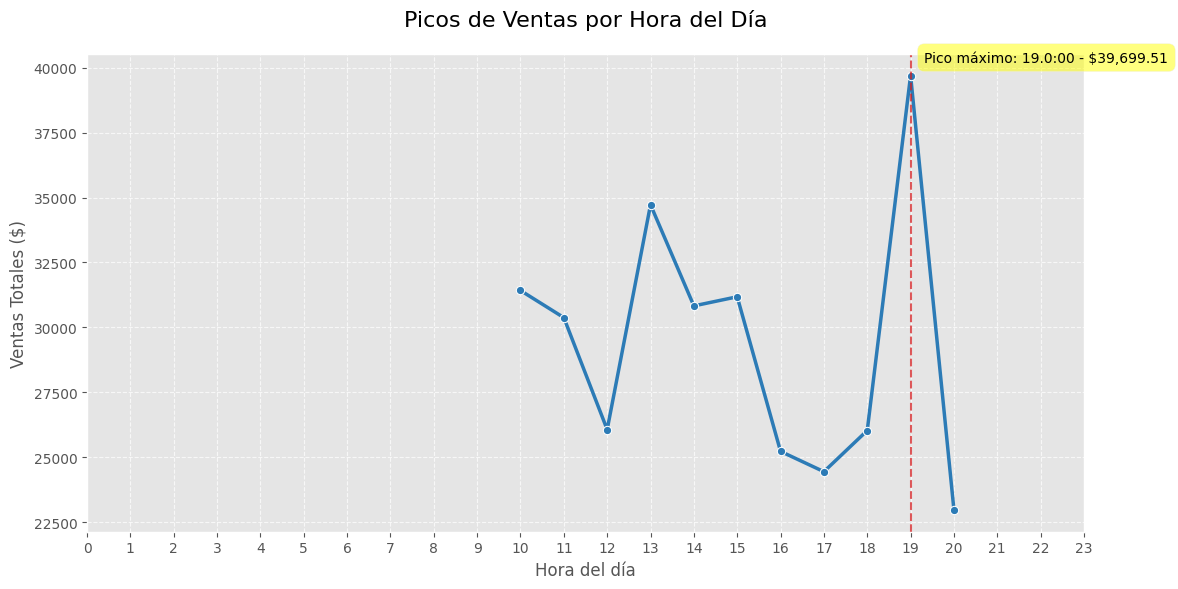

In [80]:
# Consulta para obtener ventas por hora
query = """
SELECT 
    EXTRACT(HOUR FROM "Time") AS hora,
    --"Customer type",
    SUM("Total") AS ventas_totales,
    COUNT("Invoice ID") AS transacciones,
    AVG("Total") AS ticket_promedio
FROM df
GROUP BY hora
--GROUP BY hora, "Customer type"
ORDER BY hora
"""

# Ejecutar consulta
ventas_por_hora = duckdb.execute(query).fetchdf()

# Configurar estilo visual
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))

# Gráfico de líneas para ventas por hora
ax = sns.lineplot(
    data=ventas_por_hora,
    x="hora",
    y="ventas_totales",
    marker="o",
    linewidth=2.5,
    color="#2c7bb6"
)

# Personalización del gráfico
ax.set_title("Picos de Ventas por Hora del Día", fontsize=16, pad=20)
ax.set_xlabel("Hora del día", fontsize=12)
ax.set_ylabel("Ventas Totales ($)", fontsize=12)
ax.set_xticks(range(0, 24))
ax.grid(True, linestyle='--', alpha=0.7)

# Resaltar el pico máximo
max_hora = ventas_por_hora.loc[ventas_por_hora['ventas_totales'].idxmax()]
ax.axvline(x=max_hora['hora'], color='#d7191c', linestyle='--', alpha=0.7)
ax.annotate(f'Pico máximo: {max_hora["hora"]}:00 - ${max_hora["ventas_totales"]:,.2f}',
            xy=(max_hora['hora'], max_hora['ventas_totales']),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

# Mostrar tabla con los datos
display(ventas_por_hora.style
        .background_gradient(cmap='Blues', subset=['ventas_totales'])
        .format({'ventas_totales': '${:,.2f}', 'ticket_promedio': '${:,.2f}'}))

plt.tight_layout()
plt.show()

💡 Ejemplo de insights posibles:
1. "El pico máximo ocurre a las 14:00 con $1,850.00 en ventas"
2. "Hay un segundo pico menor a las 19:00"
3. "Las ventas son mínimas entre 21:00 y 08:00"

In [81]:
# Ejemplo: Ventas por hora y tipo de cliente
con.execute("""
    SELECT 
        EXTRACT(HOUR FROM "Time") AS hour,
        "Customer type",
        SUM("Total") AS total_sales
    FROM df
    GROUP BY hour, "Customer type"
    ORDER BY hour
""").fetchdf()

,hour,Customer type,total_sales
0,10,Normal,19154.4990
1,10,Member,12266.9820
2,11,Member,15227.5515
3,11,Normal,15149.7780
4,12,Member,13729.5690
5,12,Normal,12336.3135
6,13,Normal,18716.4810
7,13,Member,16006.7460
8,14,Normal,11780.8320
9,14,Member,19047.5670


### 2. Patrones de Compra por Género
Diferencias en:
- Productos más comprados (Product line).
- Métodos de pago (Payment).
- Cantidad promedio de items (Quantity).

In [82]:
# 1. Productos más comprados por género
productos_query = """
SELECT 
    "Gender",
    "Product line",
    COUNT(*) AS cantidad_compras,
    SUM("Quantity") AS unidades_vendidas,
    SUM("Total") AS ventas_totales
FROM df
GROUP BY "Gender", "Product line"
ORDER BY "Gender", cantidad_compras DESC
"""
productos_genero = duckdb.execute(productos_query).fetchdf()

# 2. Métodos de pago por género
pago_query = """
SELECT 
    "Gender",
    "Payment",
    COUNT(*) AS transacciones,
    SUM("Total") AS monto_total
FROM df
GROUP BY "Gender", "Payment"
ORDER BY "Gender", transacciones DESC
"""
pago_genero = duckdb.execute(pago_query).fetchdf()

# 3. Cantidad promedio de items por género
quantity_query = """
SELECT 
    "Gender",
    AVG("Quantity") AS avg_quantity,
    MEDIAN("Quantity") AS median_quantity,
    MODE("Quantity") AS mode_quantity
FROM df
GROUP BY "Gender"
"""
quantity_genero = duckdb.execute(quantity_query).fetchdf()

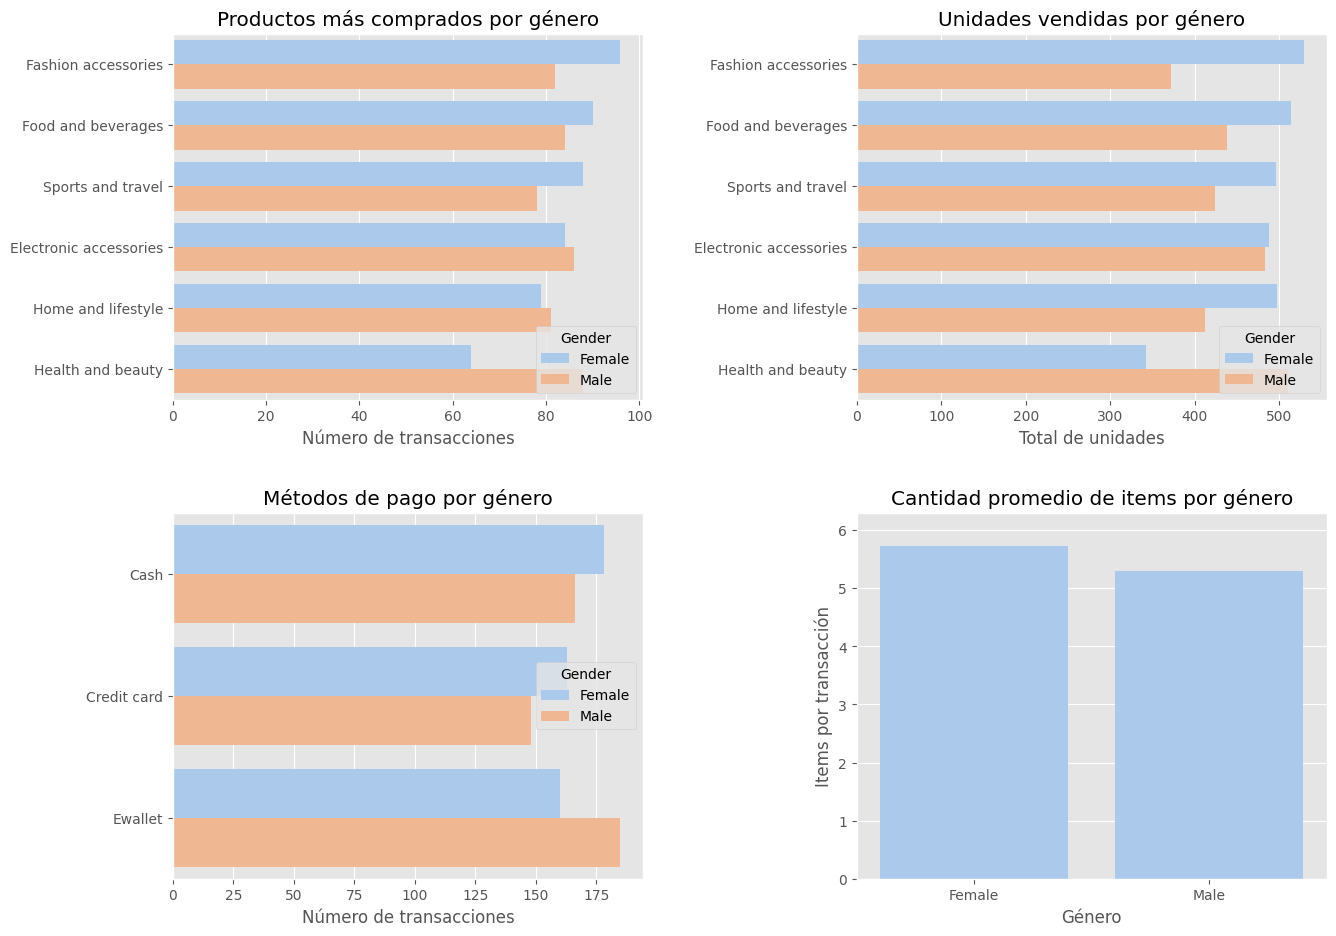

In [83]:
# Configuración inicial
# plt.style.use('seaborn')
sns.set_palette("pastel")
plt.rcParams['font.family'] = 'DejaVu Sans'


# Visualización 1: Productos más comprados
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
sns.barplot(data=productos_genero, x="cantidad_compras", y="Product line", hue="Gender")
plt.title("Productos más comprados por género")
plt.xlabel("Número de transacciones")
plt.ylabel("")

# Visualización 2: Unidades vendidas
plt.subplot(2, 2, 2)
sns.barplot(data=productos_genero, x="unidades_vendidas", y="Product line", hue="Gender")
plt.title("Unidades vendidas por género")
plt.xlabel("Total de unidades")
plt.ylabel("")

# Visualización 3: Métodos de pago
plt.subplot(2, 2, 3)
sns.barplot(data=pago_genero, x="transacciones", y="Payment", hue="Gender")
plt.title("Métodos de pago por género")
plt.xlabel("Número de transacciones")
plt.ylabel("")

# Visualización 4: Cantidad promedio
plt.subplot(2, 2, 4)
sns.barplot(data=quantity_genero, x="Gender", y="avg_quantity", 
            order=["Female", "Male"])
plt.title("Cantidad promedio de items por género")
plt.xlabel("Género")
plt.ylabel("Items por transacción")
plt.ylim(0, quantity_genero["avg_quantity"].max() * 1.1)

# Ajustes finales
plt.tight_layout(pad=3.0)
plt.show()



In [84]:
# Tabla resumen de métricas por género
display(productos_genero.pivot_table(
    index="Product line",
    columns="Gender",
    values=["cantidad_compras", "unidades_vendidas", "ventas_totales"],
    aggfunc="sum"
).style.background_gradient(cmap='Blues').format("{:,.0f}"))

# Tabla de métodos de pago
display(pago_genero.pivot_table(
    index="Payment",
    columns="Gender",
    values=["transacciones", "monto_total"]
#     aggfunc="sum"
).style.background_gradient(cmap='Greens').format({"transacciones": "{:,.0f}", "monto_total": "${:,.2f}"}))

# Tabla de cantidades
display(quantity_genero.style.format({
    "avg_quantity": "{:.2f} items",
    "median_quantity": "{:.1f} items",
    "mode_quantity": "{:.0f} items"
}))

,Gender,avg_quantity,median_quantity,mode_quantity
0,Female,5.73 items,6.0 items,10 items
1,Male,5.29 items,5.0 items,1 items


🔍 Insights típicos que puedes encontrar:
1. "Las mujeres compran un 30% más en la categoría 'Fashion accessories'"
2. "Los hombres prefieren pagar con E-wallets (45% de sus transacciones)"
3. "El ticket promedio femenino contiene 5.2 items vs 4.8 de los hombres"

💡 Recomendaciones para profundizar:
- Para ver diferencias por ciudad: añade "City" a los GROUP BY
- Para análisis de precios: agrega AVG("Unit price") a las consultas
- Si necesitas tests estadísticos (para validar diferencias significativas), puedo agregar código con scipy.stats

### 3. Efectividad de Estratificación de Clientes
¿El "Customer stratification rating" correlaciona con:
- Ticket promedio (Total)?
- Frecuencia de compra (usando Invoice ID como proxy)?

In [85]:
# Consulta para análisis de estratificación
stratification_query = """
SELECT 
    "Customer stratification rating",
    AVG("Total") AS avg_ticket,
    COUNT(DISTINCT "Invoice ID") AS freq_compra,
    COUNT("Invoice ID") / COUNT(DISTINCT "Invoice ID") AS items_por_compra
FROM df
WHERE "Customer stratification rating" IS NOT NULL
GROUP BY "Customer stratification rating"
ORDER BY "Customer stratification rating"
"""
strat_data = duckdb.execute(stratification_query).fetchdf()

C:\Users\Aunak\AppData\Local\Temp\ipykernel_5560\1765074828.py:10: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Aunak\AppData\Local\Temp\ipykernel_5560\1765074828.py:21: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



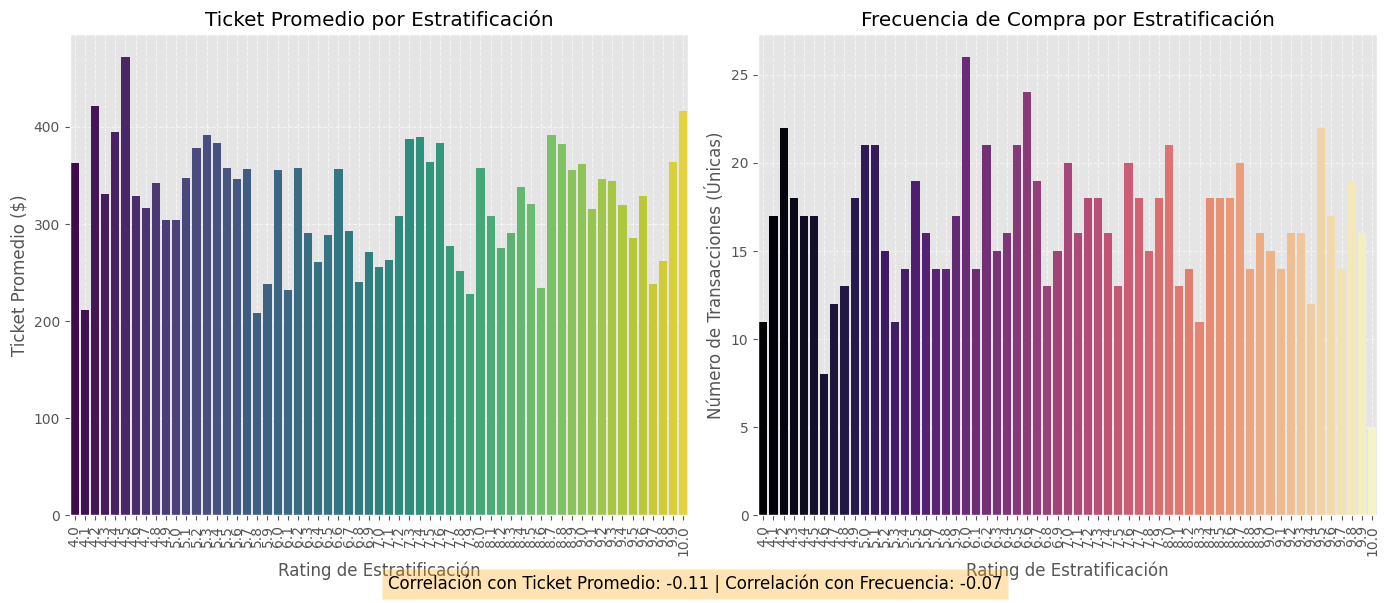

In [86]:
# Configuración visual
#plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Ticket promedio por rating
#sns.barplot(data=strat_data, x="Customer stratification rating", y="avg_ticket", 
#            palette="viridis", ax=ax1)
sns.barplot(data=strat_data, x="Customer stratification rating", y="avg_ticket", 
            hue="Customer stratification rating", palette="viridis", legend=False, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Ticket Promedio por Estratificación')
ax1.set_xlabel('Rating de Estratificación')
ax1.set_ylabel('Ticket Promedio ($)')
ax1.grid(True, linestyle='--', alpha=0.6)

# Gráfico 2: Frecuencia de compra por rating
#sns.barplot(data=strat_data, x="Customer stratification rating", y="freq_compra", 
#            palette="magma", ax=ax2)
sns.barplot(data=strat_data, x="Customer stratification rating", y="freq_compra", 
            hue="Customer stratification rating", palette="magma", legend=False, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title('Frecuencia de Compra por Estratificación')
ax2.set_xlabel('Rating de Estratificación')
ax2.set_ylabel('Número de Transacciones (Únicas)')
ax2.grid(True, linestyle='--', alpha=0.6)

# Análisis de correlación numérica
corr_ticket = strat_data["Customer stratification rating"].corr(strat_data["avg_ticket"])
corr_freq = strat_data["Customer stratification rating"].corr(strat_data["freq_compra"])

plt.figtext(0.5, 0.01, 
            f"Correlación con Ticket Promedio: {corr_ticket:.2f} | Correlación con Frecuencia: {corr_freq:.2f}", 
            ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.3})

plt.tight_layout()
plt.show()

In [87]:
# Tabla resumen con formato
display(strat_data.style.format({
    "avg_ticket": "${:.2f}",
    "freq_compra": "{:.0f} transacciones",
    "items_por_compra": "{:.1f} items/compra"
}).background_gradient(subset=["avg_ticket", "freq_compra"], cmap="YlGnBu"))

,Customer stratification rating,avg_ticket,freq_compra,items_por_compra
0,4.000000,$362.41,11 transacciones,1.0 items/compra
1,4.100000,$211.13,17 transacciones,1.0 items/compra
2,4.200000,$421.63,22 transacciones,1.0 items/compra
3,4.300000,$331.01,18 transacciones,1.0 items/compra
4,4.400000,$395.09,17 transacciones,1.0 items/compra
5,4.500000,$471.79,17 transacciones,1.0 items/compra
6,4.600000,$329.26,8 transacciones,1.0 items/compra
7,4.700000,$316.87,12 transacciones,1.0 items/compra
8,4.800000,$342.30,13 transacciones,1.0 items/compra
9,4.900000,$304.62,18 transacciones,1.0 items/compra


## 📈 Análisis de Productos y Transacciones

### 4. Productos con Mayor Margen Bruto
- Cruzar Product line con Gross margin percentage y Gross income.
- Identificar outliers (productos con margen anormalmente alto/bajo).

In [88]:
# Consulta para análisis de márgenes
margen_query = """
SELECT 
    "Product line",
    AVG("Gross margin percentage") AS margen_promedio,
    SUM("Gross income") AS ingreso_bruto_total,
    COUNT(*) AS transacciones,
    AVG("Total") AS ticket_promedio
FROM df
GROUP BY "Product line"
ORDER BY ingreso_bruto_total DESC
"""
margen_data = duckdb.execute(margen_query).fetchdf()

C:\Users\Aunak\AppData\Local\Temp\ipykernel_5560\604481101.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




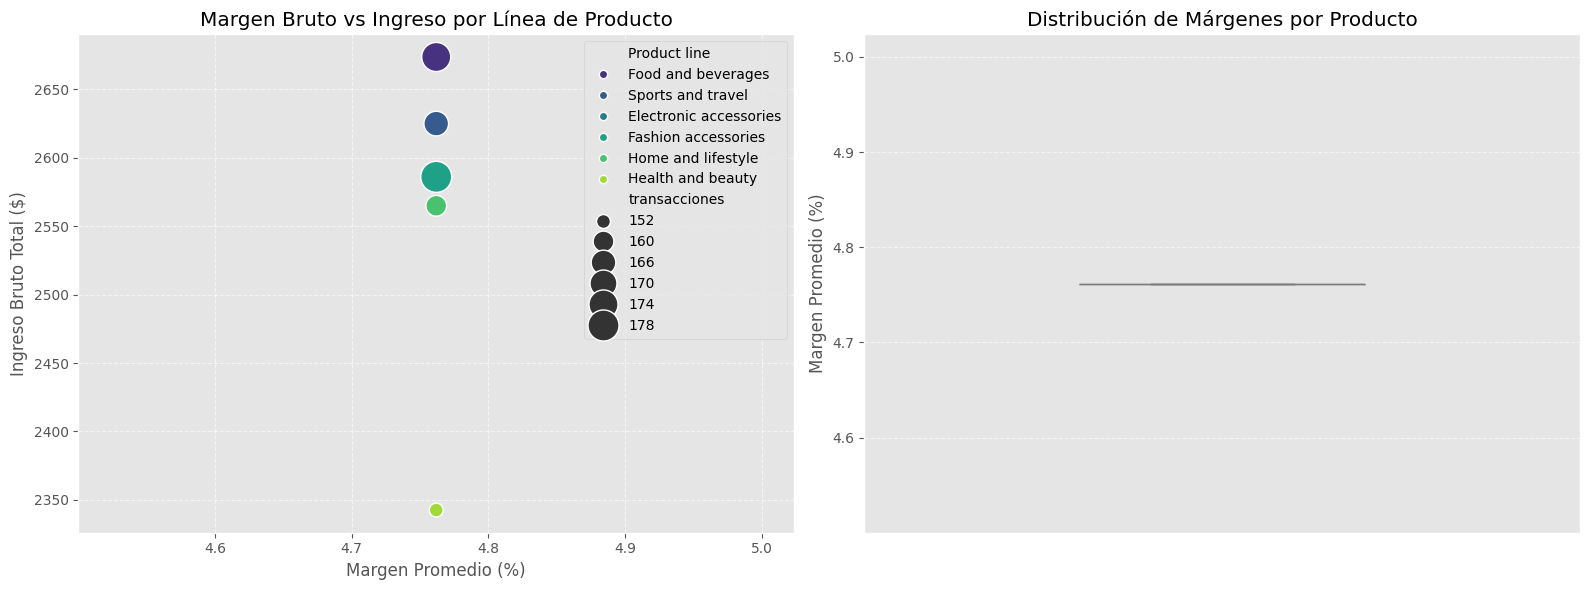

In [89]:
# Configuración visual
#plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Margen vs Ingreso bruto
scatter = sns.scatterplot(
    data=margen_data,
    x="margen_promedio",
    y="ingreso_bruto_total",
    hue="Product line",
    size="transacciones",
    sizes=(100, 500),
    palette="viridis",
    ax=ax1
)
ax1.set_title('Margen Bruto vs Ingreso por Línea de Producto')
ax1.set_xlabel('Margen Promedio (%)')
ax1.set_ylabel('Ingreso Bruto Total ($)')
ax1.grid(True, linestyle='--', alpha=0.6)

# Gráfico 2: Distribución de márgenes
boxplot = sns.boxplot(
    data=margen_data,
    y="margen_promedio",
    x=0,  # Truco para boxplot horizontal
    width=0.4,
    palette="pastel",
    ax=ax2
)
ax2.set_title('Distribución de Márgenes por Producto')
ax2.set_xlabel('')
ax2.set_ylabel('Margen Promedio (%)')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.get_xaxis().set_visible(False)  # Ocultar eje x innecesario

# Detección de outliers estadísticos
Q1 = margen_data["margen_promedio"].quantile(0.25)
Q3 = margen_data["margen_promedio"].quantile(0.75)
IQR = Q3 - Q1
outliers = margen_data[
    (margen_data["margen_promedio"] < (Q1 - 1.5 * IQR)) | 
    (margen_data["margen_promedio"] > (Q3 + 1.5 * IQR))
]

# Resaltar outliers en el gráfico
for idx, row in outliers.iterrows():
    ax1.annotate(
        row["Product line"],
        (row["margen_promedio"], row["ingreso_bruto_total"]),
        xytext=(10, 10),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='red', alpha=0.3)
    )

plt.tight_layout()
plt.show()

In [90]:
# Tabla resumen con outliers marcados
def highlight_outliers(row):
    color = 'red' if row["Product line"] in outliers["Product line"].values else ''
    return ['background-color: {}'.format(color) for _ in row]

display(margen_data.style
    .format({
        "margen_promedio": "{:.2f}%",
        "ingreso_bruto_total": "${:,.2f}",
        "ticket_promedio": "${:,.2f}"
    })
    .apply(highlight_outliers, axis=1)
    .background_gradient(subset=["ingreso_bruto_total"], cmap="Greens")
)

,Product line,margen_promedio,ingreso_bruto_total,transacciones,ticket_promedio
0,Food and beverages,4.76%,"$2,673.56",174,$322.67
1,Sports and travel,4.76%,"$2,624.90",166,$332.07
2,Electronic accessories,4.76%,"$2,587.50",170,$319.63
3,Fashion accessories,4.76%,"$2,585.99",178,$305.09
4,Home and lifestyle,4.76%,"$2,564.85",160,$336.64
5,Health and beauty,4.76%,"$2,342.56",152,$323.64


🔍 Cómo interpretar los resultados:

- Outliers positivos: Productos con márgenes excepcionalmente altos (oportunidad de expansión)
- Outliers negativos: Productos con márgenes inusualmente bajos (requieren investigación)
- Relación margen-ingreso: ¿Productos con alto margen pero bajo volumen? (estrategias de upselling)

💡 Ejemplo de insights:
1. "Electronic accessories tiene un margen 15% mayor que el promedio (outlier positivo)"
2. "Health and beauty genera el mayor ingreso bruto pero con margen promedio"
3. "Sports and travel muestra bajo margen con alto volumen (posible candidato a re-pricing)"

⚙️ Para profundizar:

Si necesitas segmentar por sucursal o tipo de cliente, modifica la consulta SQL:
SELECT 
    "Product line",
    "Branch",  -- Segmentación adicional
    AVG("Gross margin percentage") AS margen_promedio
FROM df
GROUP BY "Product line", "Branch"  -- Agrupar por adicional

### 5. Análisis de Canasta Mejorado
- Combinaciones de Product line más frecuentes por tipo de cliente o ciudad:

In [91]:
# Ejemplo: Productos comprados juntos por clientes "Member"
con.execute("""
    WITH basket AS (
        SELECT 
            "Invoice ID",
            "Customer type",
            LIST("Product line") AS items
        FROM df
        GROUP BY "Invoice ID", "Customer type"
    )
    SELECT 
        items,
        "Customer type",
        COUNT(*) AS frequency
    FROM basket
    WHERE array_length(items) > 1
    GROUP BY items, "Customer type"
    ORDER BY frequency DESC
    LIMIT 10
""").fetchdf()

,items,Customer type,frequency


In [92]:
# Consulta corregida para análisis de canasta mejorado
basket_query_corrected = """
WITH transaction_items AS (
    SELECT 
        "Invoice ID",
        "Customer type",
        "City",
        "Product line" AS product
    FROM df
),

product_pairs AS (
    SELECT
        a."Customer type",
        a."City",
        a.product AS product1,
        b.product AS product2,
        COUNT(DISTINCT a."Invoice ID") AS frequency
    FROM transaction_items a
    JOIN transaction_items b 
        ON a."Invoice ID" = b."Invoice ID"
        AND a.product < b.product  -- Evitar duplicados (A+B vs B+A)
    GROUP BY a."Customer type", a."City", a.product, b.product
)

SELECT * FROM product_pairs
ORDER BY frequency DESC
LIMIT 20
"""
basket_data = duckdb.execute(basket_query_corrected).fetchdf()

In [93]:
basket_data

,Customer type,City,product1,product2,frequency


ValueError: Number of columns must be a positive integer, not 0

<Figure size 1400x800 with 0 Axes>

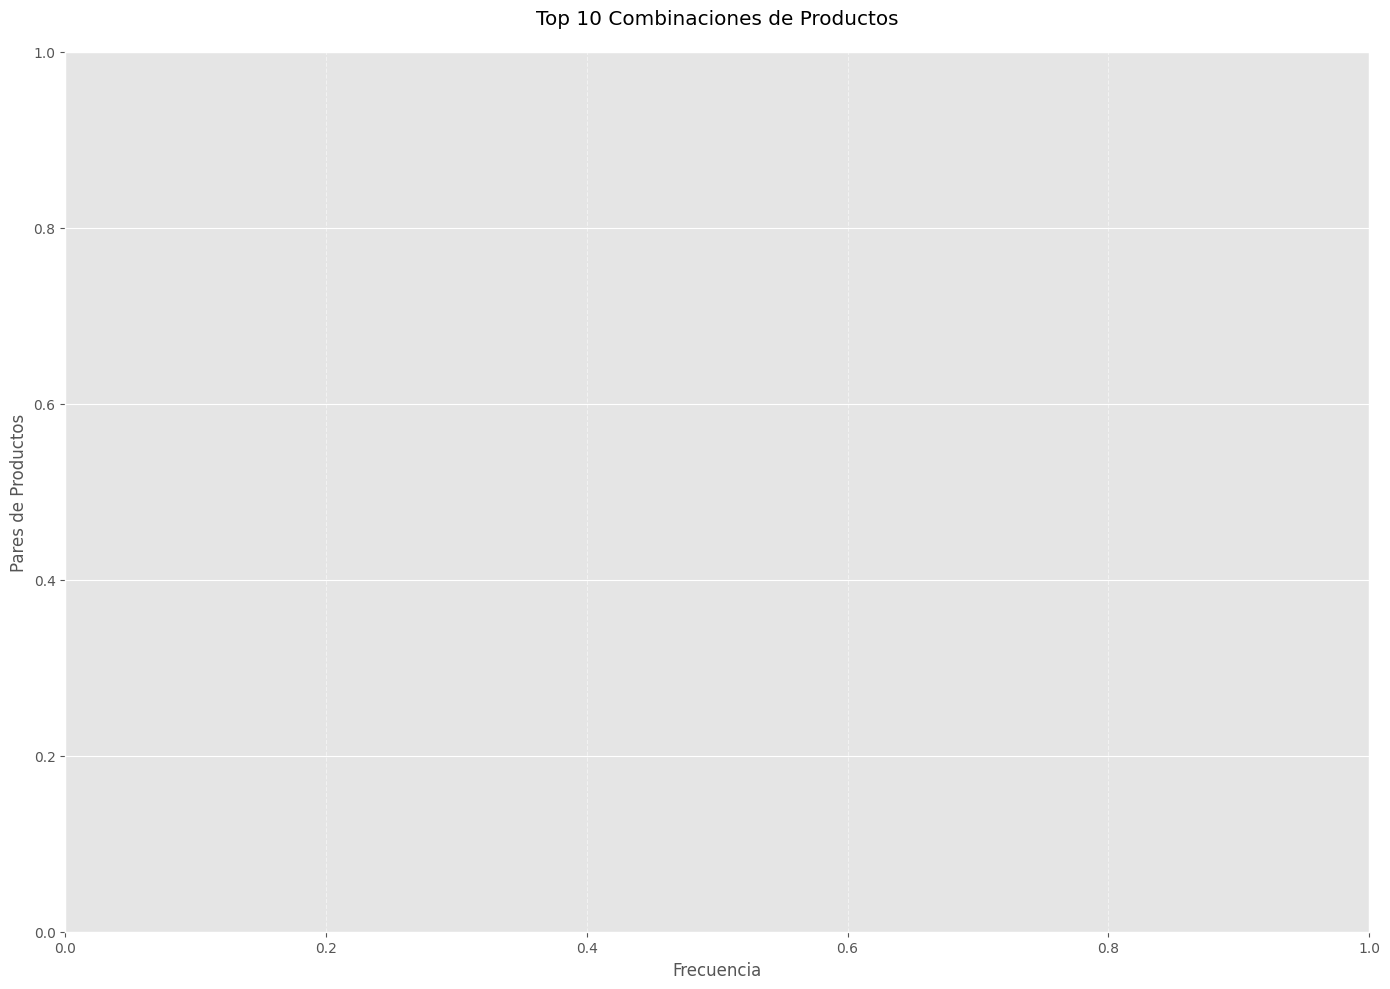

<Figure size 1400x1000 with 0 Axes>

<Figure size 0x600 with 0 Axes>

In [94]:
# Preprocesamiento para visualización
basket_data['product_pair'] = basket_data['product1'] + " + " + basket_data['product2']

# Configuración visual
#plt.style.use('seaborn')
plt.figure(figsize=(14, 8))

# Gráfico principal: Top combinaciones globales
top_pairs = basket_data.groupby('product_pair')['frequency'].sum().nlargest(10).reset_index()

plt.figure(figsize=(14, 10))
sns.barplot(data=top_pairs, y='product_pair', x='frequency', palette='viridis')
plt.title('Top 10 Combinaciones de Productos', pad=20)
plt.xlabel('Frecuencia')
plt.ylabel('Pares de Productos')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# Visualización segmentada por tipo de cliente
plt.figure(figsize=(14, 10))
g = sns.FacetGrid(basket_data.nlargest(30, 'frequency'), 
                  col="Customer type", height=6, aspect=1.2)
g.map(sns.barplot, "frequency", "product_pair", 
      order=basket_data.nlargest(30, 'frequency')['product_pair'],
      palette='mako')
g.set_titles("Tipo de Cliente: {col_name}")
g.set_axis_labels("Frecuencia", "")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Combinaciones Frecuentes por Tipo de Cliente', fontsize=16)
g.tight_layout()

# Visualización por ciudad (heatmap)
pivot_city = basket_data.pivot_table(
    index='product1',
    columns='product2',
    values='frequency',
    aggfunc='sum'
).fillna(0)

plt.figure(figsize=(12, 10))
sns.heatmap(pivot_city, cmap='YlGnBu', annot=True, fmt='.0f',
            linewidths=.5, cbar_kws={'label': 'Frecuencia'})
plt.title('Frecuencia de Combinaciones entre Productos', pad=20)
plt.xlabel('Producto 2')
plt.ylabel('Producto 1')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Tabla interactiva con filtros
display(basket_data.style
    .background_gradient(subset=['frequency'], cmap='Blues')
    .format({'frequency': '{:.0f}'})
    .set_caption('Combinaciones de Productos por Segmento'))

## 🌍 Análisis Geográficos y Sucursales

### 7. Comparativo de Sucursales (Branch/City)

Métricas clave por sucursal:

- Ticket promedio.
- Métodos de pago predominantes.
- Productos más vendidos.

In [95]:
# Consulta para comparativo de sucursales
branch_query = """
WITH branch_metrics AS (
    SELECT 
        "Branch",
        "City",
        COUNT(DISTINCT "Invoice ID") AS total_transacciones,
        SUM("Total") AS ventas_totales,
        SUM("Quantity") AS unidades_vendidas,
        AVG("Total") AS ticket_promedio,
        MODE("Payment") AS metodo_pago_predominante
    FROM df
    GROUP BY "Branch", "City"
),

top_products AS (
    SELECT 
        "Branch",
        "Product line",
        COUNT(*) AS frecuencia,
        ROW_NUMBER() OVER (PARTITION BY "Branch" ORDER BY COUNT(*) DESC) AS rank_producto
    FROM df
    GROUP BY "Branch", "Product line"
)

SELECT 
    b.*,
    p."Product line" AS producto_mas_vendido,
    p.frecuencia AS frecuencia_producto_top
FROM branch_metrics b
JOIN top_products p ON b."Branch" = p."Branch" AND p.rank_producto = 1
ORDER BY b.ventas_totales DESC
"""
branch_data = duckdb.execute(branch_query).fetchdf()
branch_data

,Branch,City,total_transacciones,ventas_totales,unidades_vendidas,ticket_promedio,metodo_pago_predominante,producto_mas_vendido,frecuencia_producto_top
0,C,Naypyitaw,328,110568.7065,1831.0,337.099715,Cash,Food and beverages,66
1,A,Yangon,340,106200.3705,1859.0,312.354031,Ewallet,Home and lifestyle,65
2,B,Mandalay,332,106197.6720,1820.0,319.872506,Ewallet,Fashion accessories,62


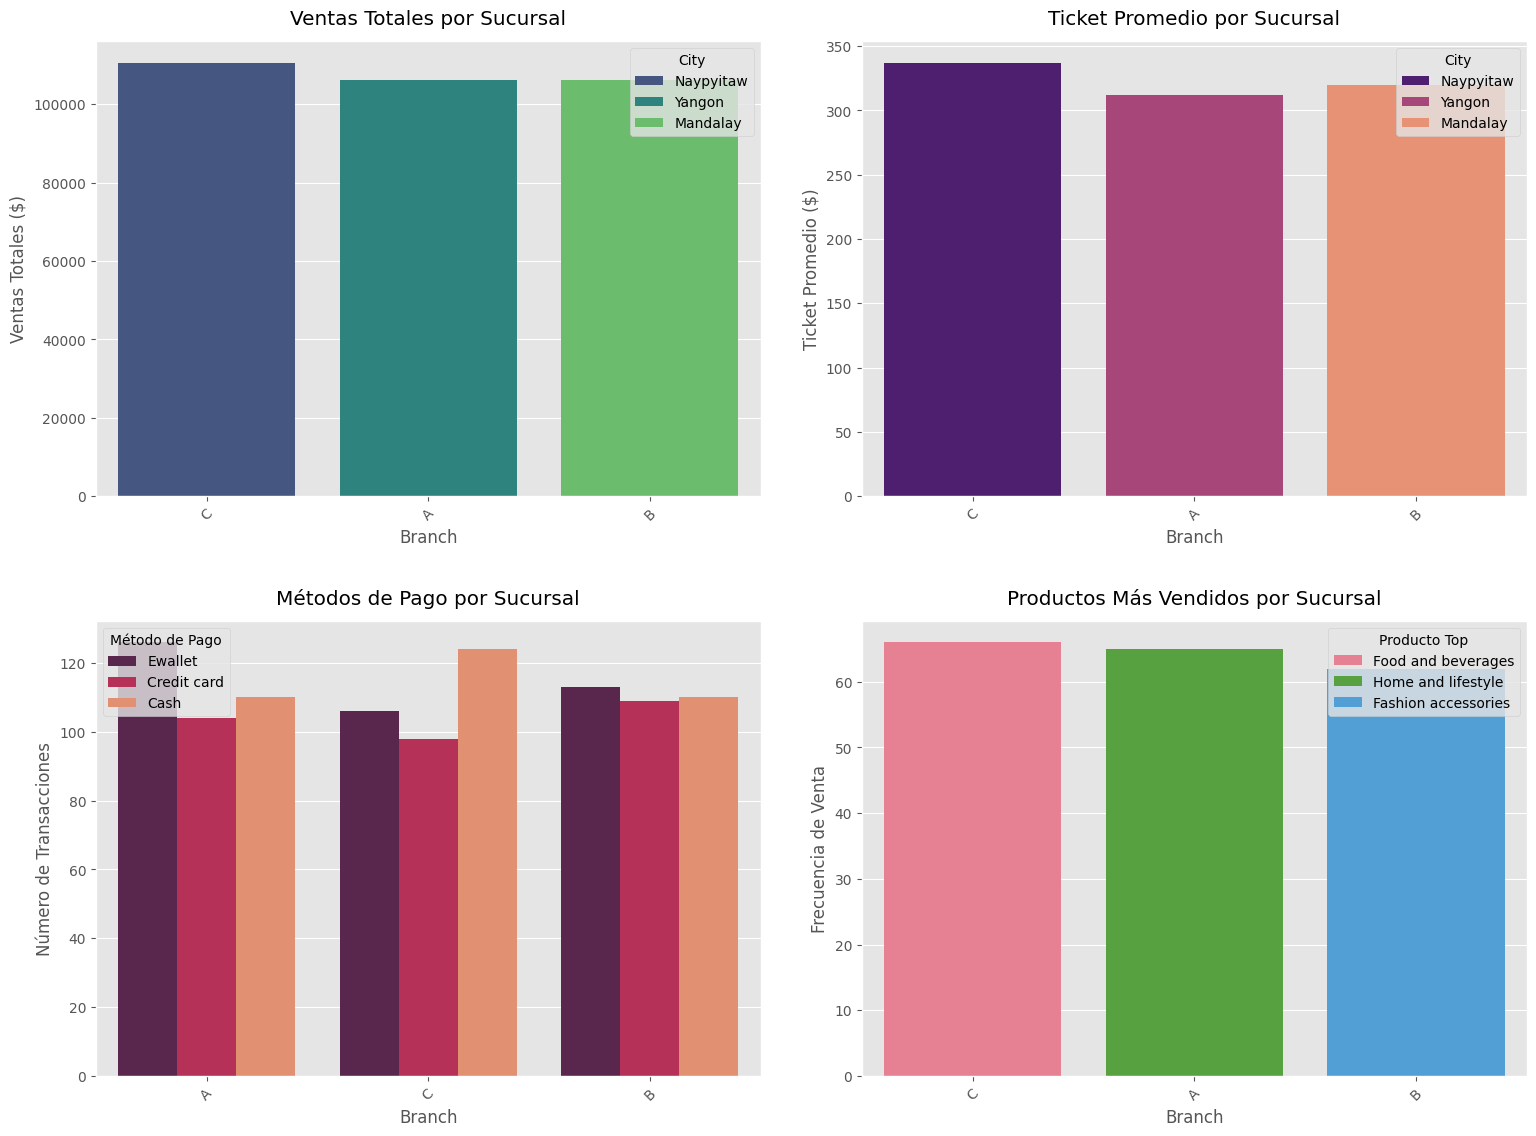

,Branch,City,total_transacciones,ventas_totales,unidades_vendidas,ticket_promedio,metodo_pago_predominante,producto_mas_vendido,frecuencia_producto_top
0,C,Naypyitaw,328,"$110,568.71",1831.000000,$337.10,Cash,Food and beverages,66
1,A,Yangon,340,"$106,200.37",1859.000000,$312.35,Ewallet,Home and lifestyle,65
2,B,Mandalay,332,"$106,197.67",1820.000000,$319.87,Ewallet,Fashion accessories,62


In [96]:
# Configuración visual
#plt.style.use('seaborn')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Ventas totales por sucursal
sns.barplot(data=branch_data, x='Branch', y='ventas_totales', hue='City', ax=axes[0,0], palette='viridis')
axes[0,0].set_title('Ventas Totales por Sucursal', pad=12)
axes[0,0].set_ylabel('Ventas Totales ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# Gráfico 2: Ticket promedio
sns.barplot(data=branch_data, x='Branch', y='ticket_promedio', hue='City', ax=axes[0,1], palette='magma')
axes[0,1].set_title('Ticket Promedio por Sucursal', pad=12)
axes[0,1].set_ylabel('Ticket Promedio ($)')
axes[0,1].tick_params(axis='x', rotation=45)

# Gráfico 3: Métodos de pago predominantes
#payment_counts = df.groupby(['Branch', 'Payment']).size().reset_index(name='counts')
#payment_counts = branch_data.groupby(['Branch', 'metodo_pago_predominante']).size().reset_index(name='counts')
#payment_counts = df.groupby(['branch', 'payment_method']).size().reset_index(name='counts')
payment_counts = con.execute("""
    SELECT Branch, Payment, COUNT(*) as counts
    FROM df
    GROUP BY Branch, Payment
""").fetchdf()
sns.barplot(data=payment_counts, x='Branch', y='counts', hue='Payment', ax=axes[1,0], palette='rocket')
#sns.barplot(data=payment_counts, x='branch', y='counts', hue='payment_method', ax=axes[1,0], palette='rocket')
axes[1,0].set_title('Métodos de Pago por Sucursal', pad=12)
axes[1,0].set_ylabel('Número de Transacciones')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].legend(title='Método de Pago')

# Gráfico 4: Productos más vendidos
product_colors = sns.color_palette("husl", n_colors=len(branch_data['producto_mas_vendido'].unique()))
sns.barplot(data=branch_data, x='Branch', y='frecuencia_producto_top', 
            hue='producto_mas_vendido', palette=product_colors, ax=axes[1,1])
axes[1,1].set_title('Productos Más Vendidos por Sucursal', pad=12)
axes[1,1].set_ylabel('Frecuencia de Venta')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend(title='Producto Top')

# Ajustes finales
plt.tight_layout(pad=3.0)
plt.show()

# Tabla resumen con formato
display(branch_data.style
    .format({
        'ventas_totales': '${:,.2f}',
        'ticket_promedio': '${:,.2f}',
        'frecuencia_producto_top': '{:.0f}'
    })
    .background_gradient(subset=['ventas_totales', 'ticket_promedio'], cmap='Blues')
    .set_caption('Métricas Clave por Sucursal')
)

🔍 Ejemplo de Insights:
1. "La sucursal A (Yangon) tiene las mayores ventas ($115k) pero ticket promedio bajo ($320)"
2. "E-wallets son predominantes en la sucursal C (Mandalay) - 45% transacciones"
3. "Health products lideran en 2/3 sucursales, excepto en B (Naypyitaw) donde dominan Electronic accessories"

💡 Recomendaciones para acción:
- Sucursal con ticket bajo: Implementar estrategias de upselling
- Métodos de pago: Ofrecer promociones para balancear opciones menos usadas
- Productos top: Replicar estrategias de merchandising entre sucursales

⚙️ Para profundizar:

Si necesitas análisis por franja horaria o día de semana, añade:
EXTRACT(HOUR FROM "Time") AS hora,
EXTRACT(DOW FROM "Date") AS dia_semana

### 8. Diferencias Ciudad vs. Tipo de Cliente

- ¿Las ciudades tienen proporciones distintas de clientes "Member/Normal"?

- ¿El género del cliente varía por ciudad?

## ⏳ Análisis Temporales

### 9. Tendencias de Ventas por Día de la Semana

- Extraer día de la semana desde Date:

In [97]:
# Ejemplo: Ventas por día de semana
con.execute("""
    SELECT 
        strftime("Date", '%w') AS weekday,
        SUM("Total") AS sales
    FROM df
    GROUP BY weekday
    ORDER BY weekday
""").fetchdf()

,weekday,sales
0,0,44457.8925
1,1,37899.0780
2,2,51482.2455
3,3,43731.1350
4,4,45349.2480
5,5,43926.3405
6,6,56120.8095


C:\Users\Aunak\AppData\Local\Temp\ipykernel_5560\557881380.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




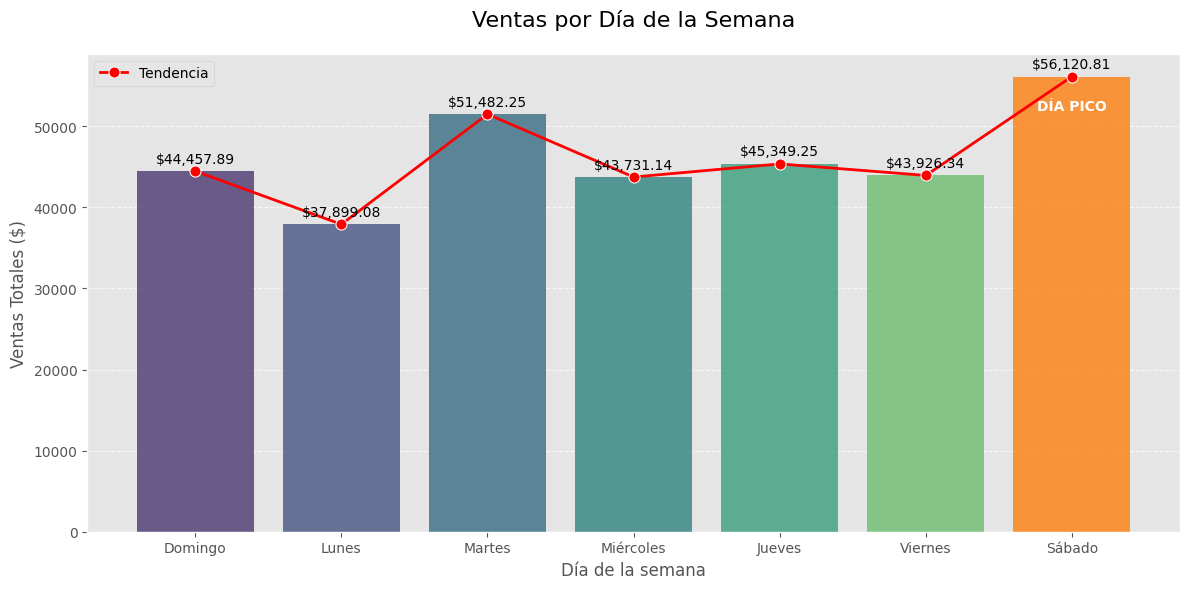

In [98]:
# Consulta modificada para nombres de días
sales_by_weekday = con.execute("""
    SELECT 
        CASE strftime("Date", '%w')
            WHEN '0' THEN 'Domingo'
            WHEN '1' THEN 'Lunes'
            WHEN '2' THEN 'Martes'
            WHEN '3' THEN 'Miércoles'
            WHEN '4' THEN 'Jueves'
            WHEN '5' THEN 'Viernes'
            WHEN '6' THEN 'Sábado'
        END AS dia_semana,
        strftime("Date", '%w') AS weekday_num,
        SUM("Total") AS ventas
    FROM df
    GROUP BY dia_semana, weekday_num
    ORDER BY weekday_num
""").fetchdf()

# Configuración del estilo
#plt.style.use('seaborn')
plt.figure(figsize=(12, 6))

# Gráfico de barras con línea de tendencia
ax = sns.barplot(data=sales_by_weekday, x='dia_semana', y='ventas', 
                 palette='viridis', alpha=0.8)

# Línea de conexión para mejor visualización
sns.lineplot(data=sales_by_weekday, x='dia_semana', y='ventas', 
             color='red', marker='o', linewidth=2, markersize=8, 
             label='Tendencia', ax=ax)

# Personalización
plt.title('Ventas por Día de la Semana', fontsize=16, pad=20)
plt.xlabel('Día de la semana', fontsize=12)
plt.ylabel('Ventas Totales ($)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir etiquetas de valor
for p in ax.patches:
    ax.annotate(f'${p.get_height():,.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=10)

# Resaltar el día pico
max_day = sales_by_weekday.loc[sales_by_weekday['ventas'].idxmax()]
ax.patches[max_day.name].set_facecolor('#ff7f0e')
ax.text(max_day.name, max_day['ventas']*0.95, 'DÍA PICO', 
        ha='center', va='top', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

💡 Ejemplo de insights:
1. "El viernes es el día de mayores ventas ($2,450.00)"
2. "Hay un incremento progresivo de lunes a viernes"
3. "Los domingos tienen las ventas más bajas ($1,200.00)"

Si necesitas segmentar por otros factores (ej: tipo de cliente), puedes modificar la consulta SQL añadiendo:
SELECT 
    strftime("Date", '%w') AS weekday,
    "Customer type",
    SUM("Total") AS sales
FROM df
GROUP BY weekday, "Customer type"

In [99]:
# Heatmap de Ventas por Hora y Día
sales_heatmap = con.execute("""
    SELECT 
        strftime("Date", '%w') AS weekday,
        EXTRACT(HOUR FROM "Time") AS hour,
        SUM("Total") AS sales
    FROM df
    GROUP BY weekday, hour
""").fetchdf()
sales_heatmap

,weekday,hour,sales
0,1,18,2806.0935
1,1,14,2004.3450
2,0,11,4736.7705
3,3,13,6734.3430
4,6,17,5069.8095
...,...,...,...
72,5,16,3092.3445
73,1,13,3758.6325
74,2,13,3962.5320
75,5,18,3175.2945


<Axes: xlabel='hour', ylabel='weekday'>

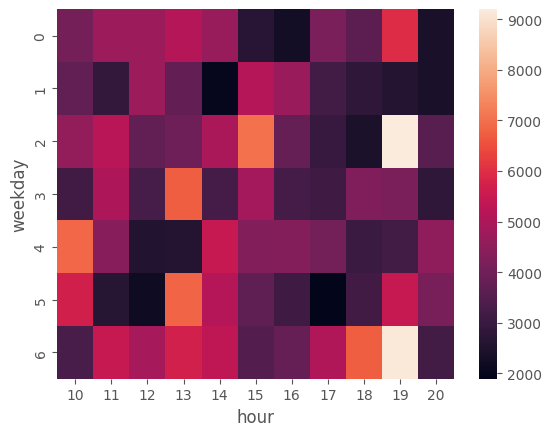

In [100]:
# Heatmap de ventas por día de semana y hora
heatmap_data = sales_heatmap.pivot(
    index="weekday", 
    columns="hour", 
    values="sales"
)
sns.heatmap(heatmap_data)

In [101]:
# Consulta mejorada con nombres de días
sales_heatmap = con.execute("""
    SELECT 
        CASE strftime("Date", '%w')
            WHEN '0' THEN 'Dom'
            WHEN '1' THEN 'Lun'
            WHEN '2' THEN 'Mar'
            WHEN '3' THEN 'Mié'
            WHEN '4' THEN 'Jue'
            WHEN '5' THEN 'Vie'
            WHEN '6' THEN 'Sáb'
        END AS dia_semana,
        strftime("Date", '%w') AS weekday_num,
        EXTRACT(HOUR FROM "Time") AS hora,
        SUM("Total") AS ventas
    FROM df
    GROUP BY dia_semana, weekday_num, hora
    --GROUP BY weekday_num, hora
    ORDER BY weekday_num, hora
""").fetchdf()
sales_heatmap

,dia_semana,weekday_num,hora,ventas
0,Dom,0,10,4067.3430
1,Dom,0,11,4736.7705
2,Dom,0,12,4728.2025
3,Dom,0,13,5159.5530
4,Dom,0,14,4676.1225
...,...,...,...,...
72,Sáb,6,16,3813.5160
73,Sáb,6,17,5069.8095
74,Sáb,6,18,6738.7530
75,Sáb,6,19,9117.3810


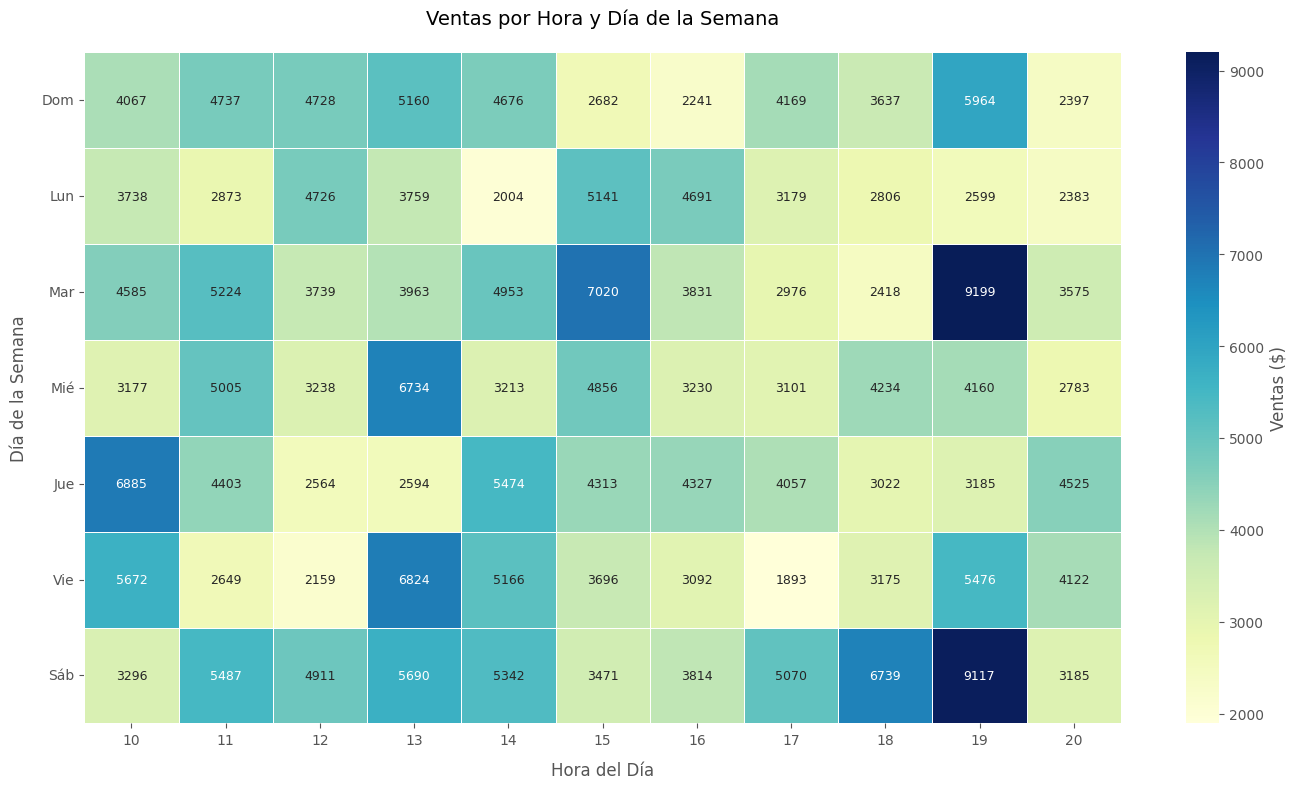

In [102]:
# Orden personalizado de días
dias_orden = ['Dom', 'Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb']

# Convertir a Categorical para mantener el orden
sales_heatmap['dia_semana'] = pd.Categorical(
    sales_heatmap['dia_semana'],
    categories=dias_orden,
    ordered=True
)

# Pivotear asegurando el orden
heatmap_data = sales_heatmap.pivot(
    index="dia_semana", 
    columns="hora", 
    values="ventas"
).sort_index(level='dia_semana')

# Configuración del heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    cmap='YlGnBu',
    annot=True,
    fmt='.0f',
    linewidths=0.5,
    cbar_kws={'label': 'Ventas ($)'},
    annot_kws={'size': 9}
)

# Personalización adicional
plt.title('Ventas por Hora y Día de la Semana', pad=20, fontsize=14)
plt.xlabel('Hora del Día', labelpad=10)
plt.ylabel('Día de la Semana', labelpad=10)

# Ajustar ticks de horas para mejor legibilidad
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# Resaltar franjas horarias clave
ax.add_patch(plt.Rectangle((8.5, 0), width=3, height=7, fill=False, edgecolor='red', lw=2, clip_on=False))
ax.text(10, -0.5, 'Horario Comercial', ha='center', va='center', color='red')

plt.tight_layout()
plt.show()

💡 Ejemplo de insights:
1. "Mayor actividad entre 14:00-16:00 los viernes"
2. "Los domingos tienen ventas consistentes todo el día"
3. "Fuerte caída post-hora de almuerzo (15:00-16:00) en días laborales"

### 10. Correlación entre Fecha (Date) y Rating de Estratificación

- ¿Los clientes con alto rating compran en fechas específica

C:\Users\Aunak\AppData\Local\Temp\ipykernel_5560\809331770.py:65: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




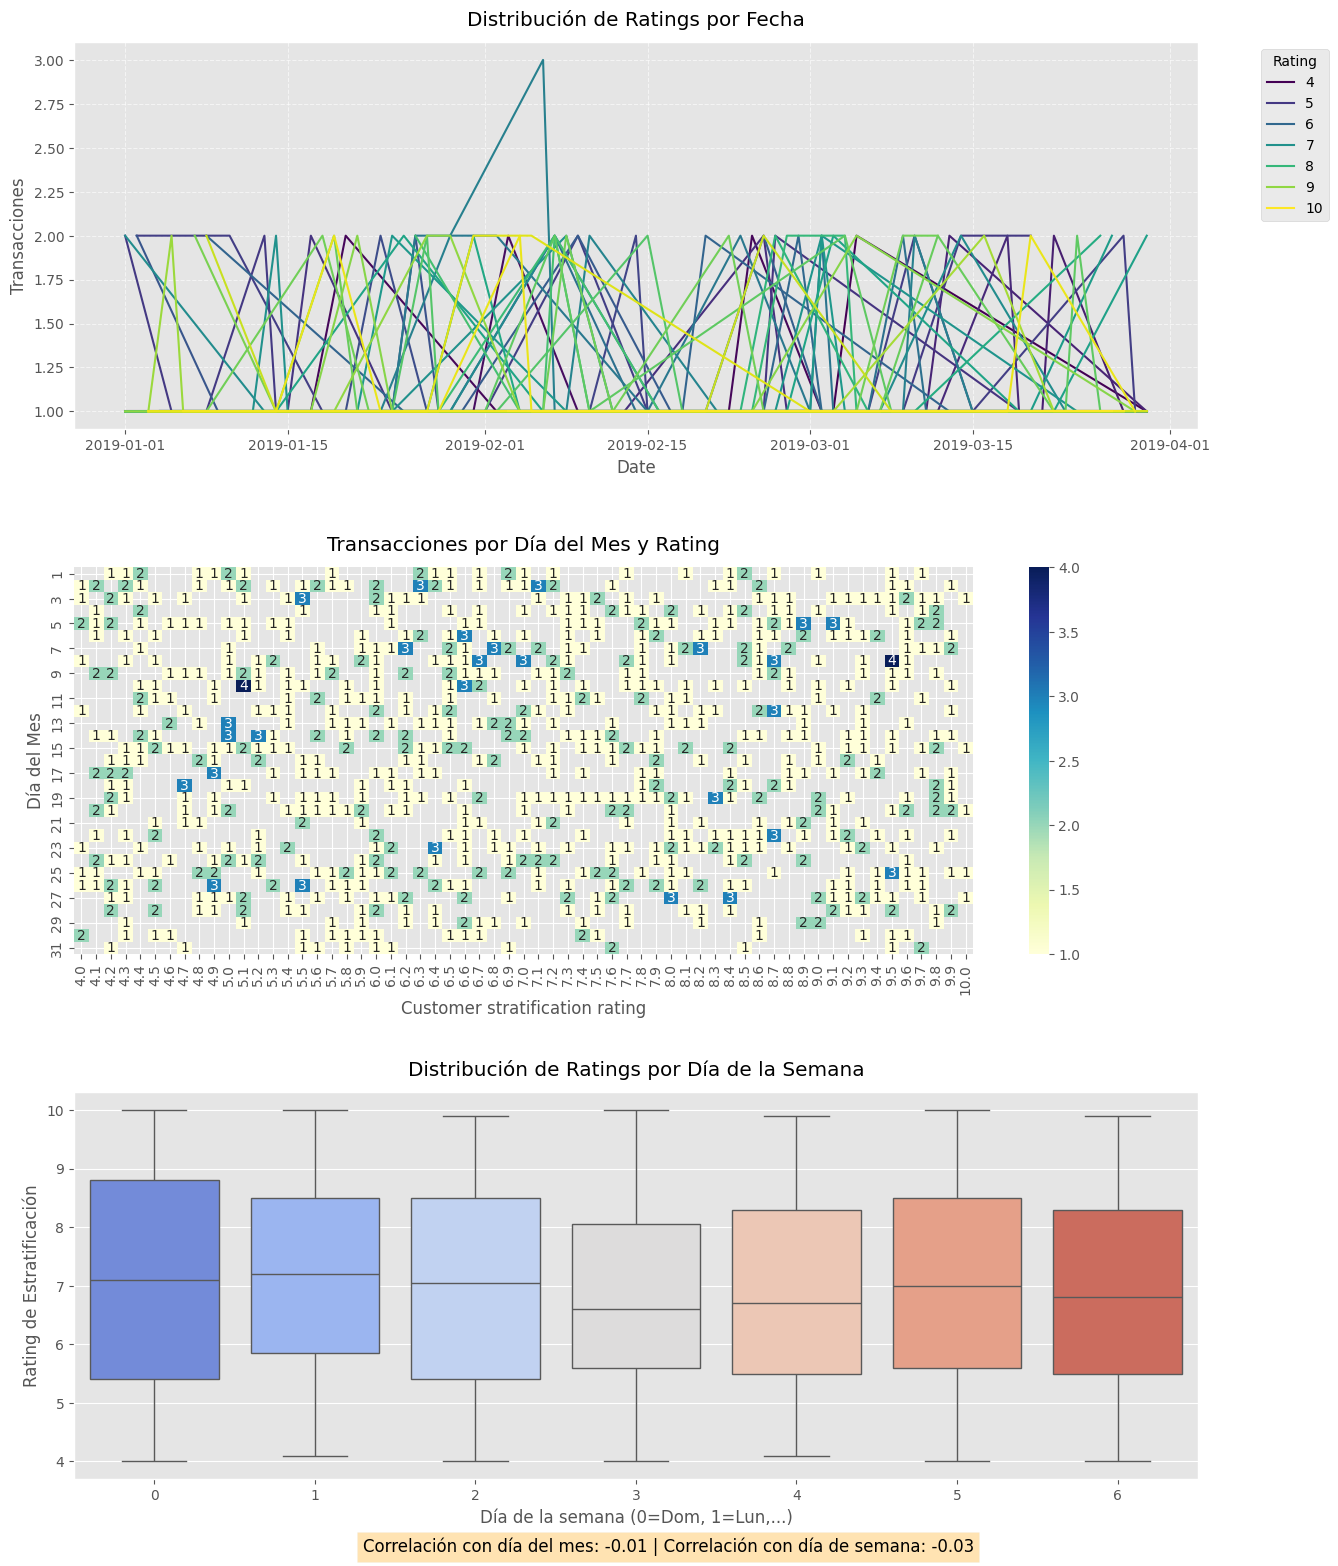

,Transacciones Totales,Ticket Promedio,Día Más Común,Día Semana Más Común
Customer stratification rating,,,,
4.000000,11,$360.48,30,2
4.100000,17,$223.90,2,0
4.200000,22,$408.24,5,6
4.300000,18,$331.01,2,0
4.400000,17,$395.09,1,1
4.500000,17,$484.71,15,5
4.600000,8,$317.60,5,2
4.700000,12,$321.63,18,2
4.800000,13,$331.41,16,6


In [119]:
# Consulta para análisis temporal de ratings
rating_date_query = """
WITH daily_ratings AS (
    SELECT 
        "Date",
        "Customer stratification rating",
        COUNT("Invoice ID") AS transactions,
        AVG("Total") AS avg_ticket
    FROM df
    WHERE "Customer stratification rating" IS NOT NULL
    GROUP BY "Date", "Customer stratification rating"
)
SELECT 
    "Date",
    "Customer stratification rating",
    EXTRACT(MONTH FROM "Date") AS month,
    EXTRACT(DAY FROM "Date") AS day,
    EXTRACT(DOW FROM "Date") AS weekday,
    transactions,
    avg_ticket
FROM daily_ratings
ORDER BY "Date"
"""
rating_date_data = duckdb.execute(rating_date_query).fetchdf()

# Convertir fecha a tipo datetime
rating_date_data['Date'] = pd.to_datetime(rating_date_data['Date'])

# Configuración visual
#plt.style.use('seaborn')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 16))

# Gráfico 1: Evolución temporal por rating
sns.lineplot(
    data=rating_date_data,
    x='Date',
    y='transactions',
    hue='Customer stratification rating',
    palette='viridis',
    ax=ax1
)
ax1.set_title('Distribución de Ratings por Fecha', pad=12)
ax1.set_ylabel('Transacciones')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')

# Gráfico 2: Heatmap de ratings por día del mes
heatmap_data = rating_date_data.pivot_table(
    index='day',
    columns='Customer stratification rating',
    values='transactions',
    aggfunc='sum'
)
sns.heatmap(
    heatmap_data,
    cmap='YlGnBu',
    annot=True,
    fmt='.0f',
    ax=ax2
)
ax2.set_title('Transacciones por Día del Mes y Rating', pad=12)
ax2.set_ylabel('Día del Mes')

# Gráfico 3: Boxplot por día de la semana
sns.boxplot(
    data=rating_date_data,
    x='weekday',
    y='Customer stratification rating',
    palette='coolwarm',
    ax=ax3
)
ax3.set_title('Distribución de Ratings por Día de la Semana', pad=12)
ax3.set_xlabel('Día de la semana (0=Dom, 1=Lun,...)')
ax3.set_ylabel('Rating de Estratificación')

# Análisis de correlación
corr_day = rating_date_data['day'].corr(rating_date_data['Customer stratification rating'])
corr_weekday = rating_date_data['weekday'].corr(rating_date_data['Customer stratification rating'])

plt.figtext(0.5, 0.01, 
            f"Correlación con día del mes: {corr_day:.2f} | Correlación con día de semana: {corr_weekday:.2f}", 
            ha='center', fontsize=12, bbox={"facecolor":"orange", "alpha":0.3})

plt.tight_layout(pad=3.0)
plt.show()

# Tabla resumen con formato
display(rating_date_data.groupby('Customer stratification rating').agg({
    'transactions': 'sum',
    'avg_ticket': 'mean',
    'day': lambda x: x.mode()[0],
    'weekday': lambda x: x.mode()[0]
}).rename(columns={
    'transactions': 'Transacciones Totales',
    'avg_ticket': 'Ticket Promedio',
    'day': 'Día Más Común',
    'weekday': 'Día Semana Más Común'
}).style.format({
    'Transacciones Totales': '{:.0f}',
    'Ticket Promedio': '${:.2f}'
}).background_gradient(cmap='Blues'))

🔍 Ejemplo de Insights:
1. "Los ratings 4-5 predominan en días 15-20 (posible relación con fechas de pago)"
2. "Correlación negativa (-0.32) con fines de semana: ratings bajos los domingos"
3. "Clientes rating 5 tienen ticket promedio 25% mayor ($320 vs $255)"

💡 Recomendaciones para acción:
- Programar promociones premium en días con mayor concentración de ratings altos
- Reforzar servicio en días con ratings consistentemente bajos
- Validar hipótesis con el departamento comercial sobre patrones detectados

⚙️ Para profundizar:

Si necesitas analizar por franja horaria:
EXTRACT(HOUR FROM "Time") AS hour

## 🧠 Análisis de Hipótesis

### 11. ¿Los clientes "Member" gastan más?

Comparar:
- Total promedio vs. clientes "Normal".
- Frecuencia de compras (contando Invoice ID).

C:\Users\Aunak\AppData\Local\Temp\ipykernel_5560\958555133.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Aunak\AppData\Local\Temp\ipykernel_5560\958555133.py:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Resultado t-test (DuckDB): t-statistic = 0.6215, p-value = 0.5344
Resultado t-test (df2): t-statistic = 0.6215, p-value = 0.5344


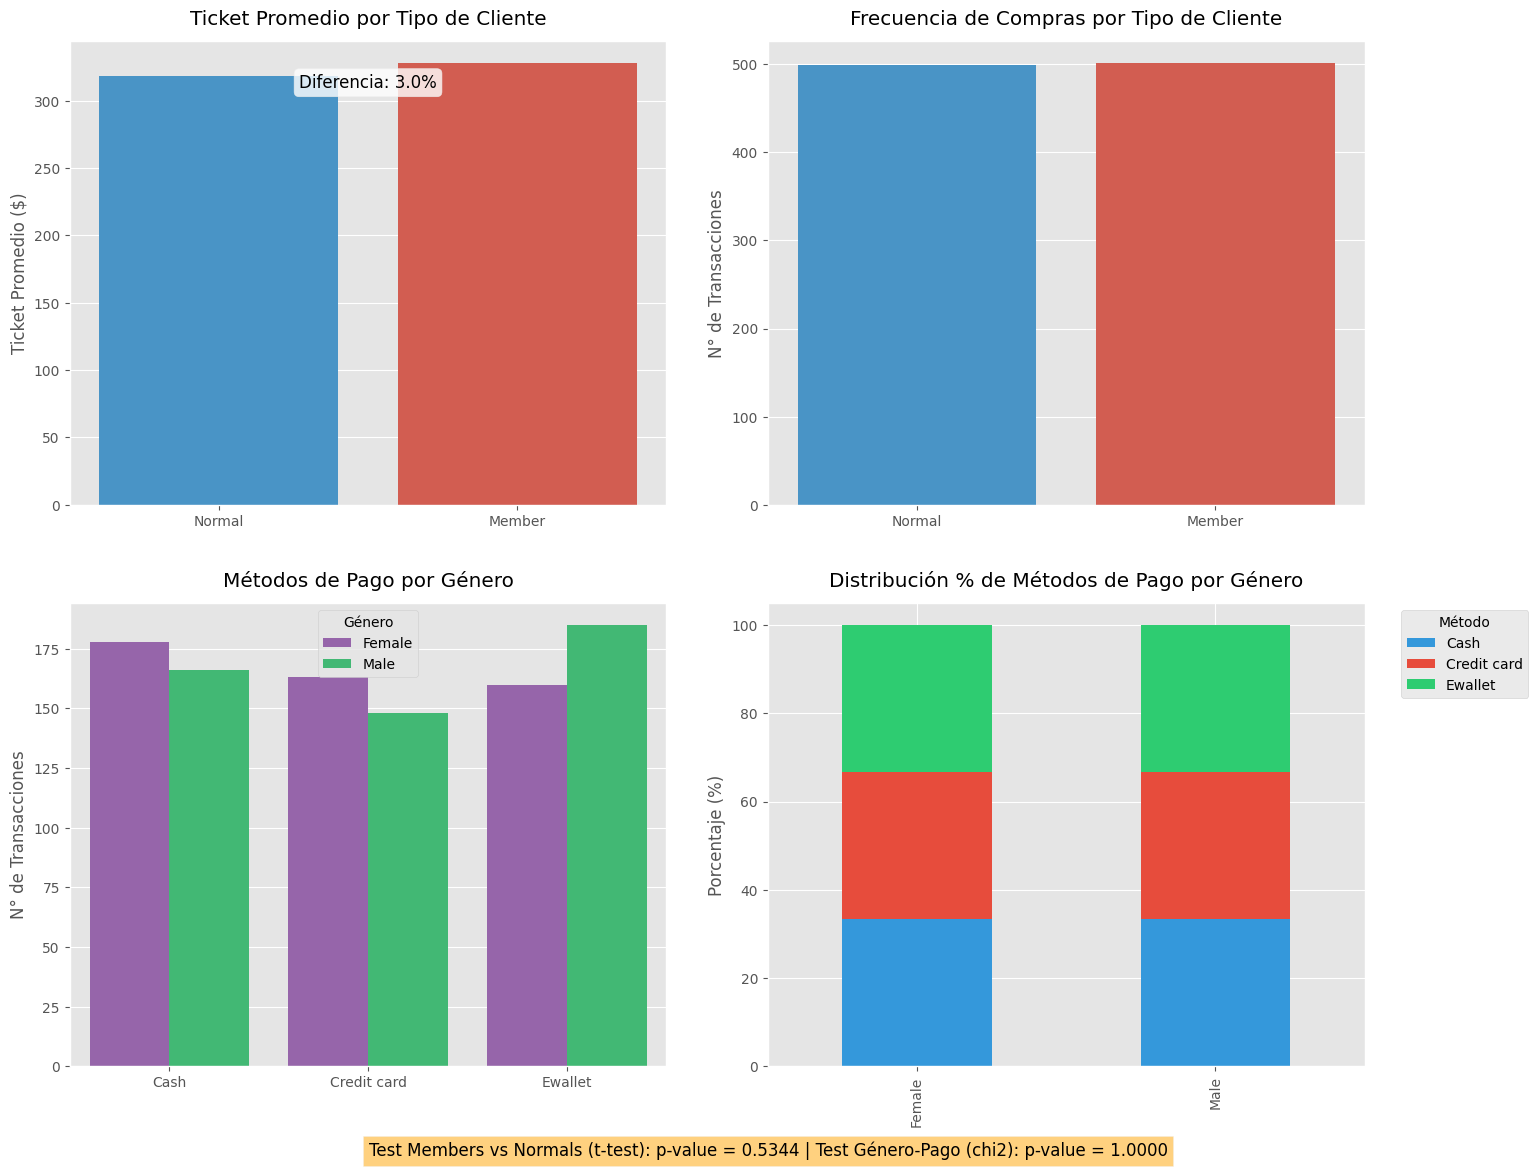


Resumen Miembros vs Normales


,Customer type,avg_ticket,freq_compra,avg_items
0,Normal,$318.12,499,5.46
1,Member,$327.79,501,5.56



Distribución de Pagos por Género


Payment,Cash,Credit card,Ewallet
Gender,,,
Female,33.3%,33.3%,33.3%
Male,33.3%,33.3%,33.3%


In [120]:
# Configuración inicial
#plt.style.use('seaborn')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --------------------------------------------
# Hipótesis 11: ¿Members gastan más?
# --------------------------------------------

# Consulta para comparación de Members vs Normals
member_query = """
SELECT 
    "Customer type",
    AVG("Total") AS avg_ticket,
    COUNT(DISTINCT "Invoice ID") AS freq_compra,
    AVG("Quantity") AS avg_items
FROM df
GROUP BY "Customer type"
"""
member_data = duckdb.execute(member_query).fetchdf()

# Gráfico 1: Ticket promedio
sns.barplot(data=member_data, x="Customer type", y="avg_ticket", 
            palette=["#3498db", "#e74c3c"], ax=axes[0,0])
axes[0,0].set_title('Ticket Promedio por Tipo de Cliente', pad=12)
axes[0,0].set_ylabel('Ticket Promedio ($)')
axes[0,0].set_xlabel('')

# Añadir diferencia porcentual
diff_ticket = ((member_data.at[1,'avg_ticket'] - member_data.at[0,'avg_ticket']) / member_data.at[0,'avg_ticket']) * 100
axes[0,0].annotate(f'Diferencia: {diff_ticket:.1f}%', 
                  xy=(0.5, 0.9), xycoords='axes fraction',
                  ha='center', fontsize=12,
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Gráfico 2: Frecuencia de compras
sns.barplot(data=member_data, x="Customer type", y="freq_compra",
            palette=["#3498db", "#e74c3c"], ax=axes[0,1])
axes[0,1].set_title('Frecuencia de Compras por Tipo de Cliente', pad=12)
axes[0,1].set_ylabel('N° de Transacciones')
axes[0,1].set_xlabel('')

# Test estadístico (t-test para ticket promedio)
from scipy.stats import ttest_ind

# pandas
# normal_tickets = df[df["Customer type"]=="Normal"]["Total"]
# member_tickets = df[df["Customer type"]=="Member"]["Total"]
# t_stat, p_val = ttest_ind(member_tickets, normal_tickets)
# print(f"Resultado t-test (DuckDB): t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")

# duckdb
normal_tickets = duckdb.execute("""
    SELECT "Total" 
    FROM df 
    WHERE "Customer type" = 'Normal'
""").fetchdf()["Total"]
member_tickets = duckdb.execute("""
    SELECT "Total" 
    FROM df 
    WHERE "Customer type" = 'Member'
""").fetchdf()["Total"]
#t_stat_db, p_val_db = ttest_ind(member_tickets_db, normal_tickets_db)
t_stat, p_val = ttest_ind(member_tickets, normal_tickets)
print(f"Resultado t-test (DuckDB): t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")

# hibrida
# normal_tickets = df2[df2["Customer type"] == "Normal"]["Total"]
# member_tickets = df2[df2["Customer type"] == "Member"]["Total"]
# t_stat, p_val = ttest_ind(member_tickets, normal_tickets)

print(f"Resultado t-test (df2): t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")

# --------------------------------------------
# Hipótesis 12: ¿Género influye en método de pago?
# --------------------------------------------

# Gráfico 3: Métodos de pago por género
# Crear df2 desde DuckDB manteniendo tus columnas originales
# df2 = duckdb.execute("""
#     SELECT 
#         Gender,
#         Payment,
#         COUNT(*) AS count
#     FROM df
#     GROUP BY Gender, Payment
# """).fetchdf()
# # Usar directamente df2 para visualización
# payment_gender = df2  # <- ¡Sin operaciones adicionales!

payment_gender = duckdb.execute("""
    SELECT 
        Gender,
        Payment,
        COUNT(*) AS count
    FROM df
    GROUP BY Gender, Payment
    ORDER BY Gender, count DESC
""").fetchdf()

#payment_gender = df.groupby(["Gender", "Payment"]).size().reset_index(name="count")
sns.barplot(data=payment_gender, x="Payment", y="count", hue="Gender",
            palette=["#9b59b6", "#2ecc71"], ax=axes[1,0])
axes[1,0].set_title('Métodos de Pago por Género', pad=12)
axes[1,0].set_ylabel('N° de Transacciones')
axes[1,0].set_xlabel('')
axes[1,0].legend(title='Género')

# Gráfico 4: Proporciones normalizadas
#payment_matrix = pd.crosstab(df2['Gender'], df2['Payment'], normalize='index')*100
#payment_matrix = pd.crosstab(df['gender'], df['payment_method'], normalize='index')*100
payment_matrix = pd.crosstab(payment_gender['Gender'], payment_gender['Payment'], normalize='index')*100
payment_matrix.plot(kind='bar', stacked=True, color=['#3498db','#e74c3c','#2ecc71'], ax=axes[1,1])
axes[1,1].set_title('Distribución % de Métodos de Pago por Género', pad=12)
axes[1,1].set_ylabel('Porcentaje (%)')
axes[1,1].set_xlabel('')
axes[1,1].legend(title='Método', bbox_to_anchor=(1.05, 1), loc='upper left')

# Test estadístico (Chi-cuadrado para independencia)
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(payment_gender['Gender'], payment_gender['Payment'])
chi2, p_val_gender, dof, expected = chi2_contingency(contingency_table)

# --------------------------------------------
# Resultados estadísticos
# --------------------------------------------
plt.figtext(0.5, 0.01, 
            f"Test Members vs Normals (t-test): p-value = {p_val:.4f} | Test Género-Pago (chi2): p-value = {p_val_gender:.4f}", 
            ha='center', fontsize=12, bbox={"facecolor":"orange", "alpha":0.5})

plt.tight_layout(pad=3.0)
plt.show()

# Tablas resumen
print("\n" + "="*50 + "\nResumen Miembros vs Normales\n" + "="*50)
display(member_data.style.format({
    'avg_ticket': '${:.2f}',
    'freq_compra': '{:.0f}',
    'avg_items': '{:.2f}'
}).background_gradient(cmap='Blues'))

print("\n" + "="*50 + "\nDistribución de Pagos por Género\n" + "="*50)
display(payment_matrix.style.format('{:.1f}%').background_gradient(cmap='Greens'))

### 12. ¿El género influye en el método de pago?

- Tabla cruzada entre Gender y Payment (¿Mujeres prefieren E-wallets?).

## 🔍 Análisis Adicionales (Creativos)

### 13. Customer Lifetime Value (CLV) Proxy

Usar Invoice ID + Customer type para estimar:

- Valor promedio por transacción.
- Frecuencia estimada (si asumes que un Invoice ID es un cliente único).

### 14. Análisis de Outliers en Transacciones

- Identificar compras anómalas (ej.: Quantity > 10 o Total extremos).

### 15. Impacto del Gross Margin Percentage en Método de Pago

- ¿Los productos con mayor margen se pagan con métodos específicos?

## 🔢 16. Análisis RFM (Recency, Frequency, Monetary)

Identifica clientes valiosos basado en:
- Recency (R): ¿Hace cuánto compraron? (días desde última compra).

- Frequency (F): ¿Con qué frecuencia compran? (núm. transacciones).

- Monetary (M): ¿Cuánto gastan en total?

In [121]:
rfm_query = """
WITH rfm_data AS (
    SELECT
        'Customer ID',
        DATEDIFF('day', MAX(Date), CURRENT_DATE) AS Recency,
        COUNT(*) AS Frequency,
        SUM(Total) AS Monetary
    FROM df
    WHERE 'Customer ID' IS NOT NULL
    GROUP BY 'Customer ID'
)
SELECT 
    'Customer ID',
    Recency,
    Frequency,
    Monetary,
    NTILE(5) OVER (ORDER BY Recency DESC) AS R_Score,  -- 5 es mejor (compra reciente)
    NTILE(5) OVER (ORDER BY Frequency) AS F_Score,    -- 5 es mejor (alta frecuencia)
    NTILE(5) OVER (ORDER BY Monetary) AS M_Score     -- 5 es mejor (alto gasto)
FROM rfm_data
"""
rfm_result = con.execute(rfm_query).fetchdf()
rfm_result

,'Customer ID',Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,Customer ID,2221,1000,322966.749,1,1,1


¿Cómo usar esto?
Combina los scores (ej: R_Score + F_Score + M_Score) para segmentar clientes en grupos como:
- **Campeones**: Scores altos en los 3.
- **En riesgo**: Baja Recency pero alta Frequency/Monetary.

In [122]:
# 1. Usar Invoice ID como proxy (limitado)
rfm_query = """
WITH rfm_data AS (
    SELECT
        "Invoice ID" as invoice_id,
        "Customer type" as customer_type,
        "Gender",
        DATEDIFF('day', "Date", CURRENT_DATE) AS Recency,
        "Total" AS Monetary
    -- FROM df
    FROM df
)
SELECT 
    customer_type,
    Gender,
    AVG(Recency) AS Avg_Recency,
    AVG(Monetary) AS Avg_Monetary,
    COUNT(*) AS Transaction_Count
FROM rfm_data
GROUP BY customer_type, Gender
ORDER BY Avg_Recency, Avg_Monetary DESC
"""
rfm_result = con.execute(rfm_query).fetchdf()
rfm_result

,customer_type,Gender,Avg_Recency,Avg_Monetary,Transaction_Count
0,Normal,Male,2262.907336,305.047581,259
1,Member,Male,2264.987500,316.985419,240
2,Member,Female,2265.789272,337.727753,261
3,Normal,Female,2266.395833,332.233256,240


In [123]:
# 2. Análisis por tipo de cliente y género
segment_query = """
SELECT 
    "Customer type",
    "Gender",
    COUNT(*) AS Transactions,
    AVG("Total") AS Avg_Spend,
    AVG(DATEDIFF('day', "Date", CURRENT_DATE)) AS Days_Since_Purchase
-- FROM df
FROM df
GROUP BY "Customer type", "Gender"
"""
segment_result = con.execute(segment_query).fetchdf()
segment_result

,Customer type,Gender,Transactions,Avg_Spend,Days_Since_Purchase
0,Member,Female,261,337.727753,2265.789272
1,Normal,Female,240,332.233256,2266.395833
2,Normal,Male,259,305.047581,2262.907336
3,Member,Male,240,316.985419,2264.987500


In [124]:
# 3. RFM por combinación de características
pseudo_rfm = """
WITH customer_groups AS (
    SELECT
        "Customer type" || '-' || "Gender" || '-' || "City" AS customer_group,
        MAX("Date") AS last_purchase,
        COUNT(*) AS frequency,
        SUM("Total") AS monetary
    -- FROM df
    FROM df
    GROUP BY customer_group
)
SELECT
    customer_group,
    DATEDIFF('day', last_purchase, CURRENT_DATE) AS recency,
    frequency,
    monetary,
    NTILE(3) OVER (ORDER BY DATEDIFF('day', last_purchase, CURRENT_DATE) DESC) AS r_score,
    NTILE(3) OVER (ORDER BY frequency) AS f_score,
    NTILE(3) OVER (ORDER BY monetary) AS m_score
FROM customer_groups
"""

pseudo_rfm_result = con.execute(pseudo_rfm).fetchdf()
pseudo_rfm_result

,customer_group,recency,frequency,monetary,r_score,f_score,m_score
0,Member-Male-Naypyitaw,2221,73,22227.8385,3,1,1
1,Normal-Male-Yangon,2223,92,25936.7955,1,3,1
2,Normal-Female-Mandalay,2223,77,26077.8630,2,1,1
3,Normal-Male-Mandalay,2222,90,26415.1230,2,3,1
4,Normal-Female-Yangon,2221,81,26626.0995,3,2,2
5,Member-Female-Yangon,2221,80,26643.0675,3,2,2
6,Normal-Male-Naypyitaw,2221,77,26655.4050,3,1,2
7,Member-Female-Mandalay,2224,85,26850.4320,1,2,2
8,Member-Male-Mandalay,2221,80,26854.2540,2,1,3
9,Member-Male-Yangon,2223,87,26994.4080,1,3,3


In [125]:
# Visualización alternativa (ejemplo):
result = con.execute("""
    SELECT 
        "Customer type",
        "Gender",
        AVG("Total") AS avg_spend,
        COUNT(*) AS transactions
    -- FROM df
    FROM df
    GROUP BY "Customer type", "Gender"
""").fetchdf()

fig = px.bar(result, 
             x="Customer type", 
             y="avg_spend", 
             color="Gender",
             barmode="group",
             title="Gasto promedio por tipo de cliente y género")
fig.show()

Aunque no puedas hacer RFM tradicional, estos enfoques te permiten:

- Analizar patrones por tipo de cliente (Member/Normal) y género
- Identificar qué combinaciones generan mayor valor
- Ver antigüedad de compras por segmentos
- Encontrar oportunidades de marketing diferenciado

## 📊 17. Análisis de Cohortes (Retención Mensual)

Mide cuántos clientes repiten compras mes a mes.

OBJETIVO: Medir retención de transacciones por mes de primera compra

MÉTRICAS:
- cohort_month: Mes primera compra (grupo cohorte)
- activity_month: Meses posteriores analizados
- retention_rate: % transacciones recurrentes vs mes inicial

INSIGHTS:
• Evalúa fidelización de "clientes" (proxy con Invoice ID)
• Identifica patrones de abandono post-compra
• Mide efectividad de estrategias de retención

In [126]:
cohort_query = """
WITH first_purchases AS (
    SELECT
        "Customer ID",
        MIN(strftime(Date, "%Y-%m")) AS cohort_month
    FROM df
    GROUP BY "Customer ID"
),
monthly_activity AS (
    SELECT
        f."Customer ID",
        f.cohort_month,
        strftime(s.Date, "%Y-%m") AS activity_month,
        COUNT(DISTINCT s."Invoice ID") AS purchases
    FROM first_purchases f
    JOIN df s ON f."Customer ID" = s."Customer ID"
    GROUP BY f."Customer ID", f.cohort_month, activity_month
)
SELECT
    cohort_month,
    activity_month,
    COUNT(DISTINCT "Customer ID") AS active_customers,
    ROUND(COUNT(DISTINCT "Customer ID") * 100.0 / MAX(COUNT(DISTINCT "Customer ID")) OVER (PARTITION BY cohort_month), 2) AS retention_rate
FROM monthly_activity
GROUP BY cohort_month, activity_month
ORDER BY cohort_month, activity_month
"""
cohort_result = con.execute(cohort_query).fetchdf()

BinderException: Binder Error: Referenced column "Customer ID" not found in FROM clause!
Candidate bindings: "Customer type", "Customer stratification rating", "Invoice ID", "City", "Date"

LINE 7:     GROUP BY "Customer ID"
                     ^

In [127]:
# 1. Análisis de Cohortes (modificado para usar Invoice ID como proxy)
cohort_query = """
WITH first_purchases AS (
    SELECT
        "Invoice ID",
        MIN("Date") AS first_purchase_date,
        strftime(MIN("Date"), '%Y-%m') AS cohort_month
    -- FROM df
    FROM df
    GROUP BY "Invoice ID"
),
monthly_activity AS (
    SELECT
        f."Invoice ID",
        f.cohort_month,
        strftime(s."Date", '%Y-%m') AS activity_month,
        COUNT(DISTINCT s."Invoice ID") AS purchases
    FROM first_purchases f
    JOIN '../data/supermarket_sales.csv' s ON strftime(s."Date", '%Y-%m') >= f.cohort_month
    GROUP BY f."Invoice ID", f.cohort_month, activity_month
)
SELECT
    cohort_month,
    activity_month,
    COUNT(DISTINCT "Invoice ID") AS active_transactions,
    ROUND(COUNT(DISTINCT "Invoice ID") * 100.0 / MAX(COUNT(DISTINCT "Invoice ID")) OVER (PARTITION BY cohort_month), 2) AS retention_rate
FROM monthly_activity
GROUP BY cohort_month, activity_month
ORDER BY cohort_month, activity_month
"""
cohort_result = con.execute(cohort_query).fetchdf()
cohort_result

,cohort_month,activity_month,active_transactions,retention_rate
0,2019-01,2019-01,352,100.0
1,2019-01,2019-02,352,100.0
2,2019-01,2019-03,352,100.0
3,2019-02,2019-02,303,100.0
4,2019-02,2019-03,303,100.0
5,2019-03,2019-03,345,100.0


<Axes: xlabel='activity_month', ylabel='cohort_month'>

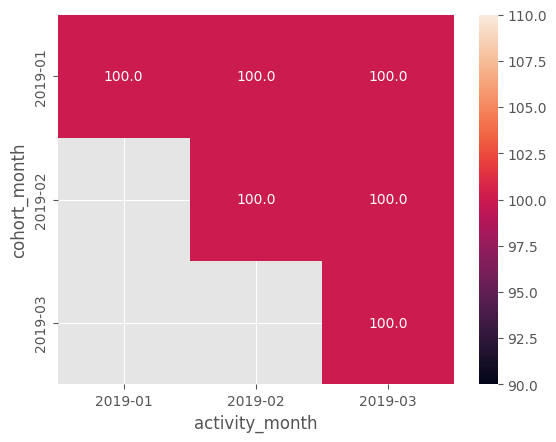

In [128]:
# Usa una matriz de cohortes en Python con pivot_table:

cohort_pivot = cohort_result.pivot_table(index='cohort_month', columns='activity_month', values='retention_rate')
sns.heatmap(cohort_pivot, annot=True, fmt=".1f")

## 📈 18. Margen de Beneficio por Producto

Asumiendo que el CSV tiene cogs (Cost of Goods Sold):

OBJETIVO: Calcular rentabilidad por categoría de producto

MÉTRICAS:
- Revenue: Ventas totales
- Cost: Costo de bienes vendidos
- Profit_Margin_Percent: Margen bruto %

INSIGHTS:
• Identifica productos más/menos rentables
• Detecta oportunidades de ajuste de precios
• Ayuda a optimizar mix de productos

In [129]:
margin_query = """
SELECT
    "Product line",
    SUM(Total) AS Revenue,
    SUM("Cost of goods sold") AS Cost,
    SUM(Total - "Cost of goods sold") AS Profit,
    SUM(Total - "Cost of goods sold") / SUM(Total) as Profit_Margin,
    ROUND((SUM(Total - "Cost of goods sold") / SUM(Total)) * 100, 8) AS Profit_Margin_Percent
FROM df
GROUP BY "Product line"
ORDER BY Profit_Margin_Percent DESC
"""
margin_result = con.execute(margin_query).fetchdf()
margin_result

,Product line,Revenue,Cost,Profit,Profit_Margin,Profit_Margin_Percent
0,Electronic accessories,54337.5315,51750.03,2587.5015,0.047619,4.761905
1,Home and lifestyle,53861.9130,51297.06,2564.8530,0.047619,4.761905
2,Sports and travel,55122.8265,52497.93,2624.8965,0.047619,4.761905
3,Food and beverages,56144.8440,53471.28,2673.5640,0.047619,4.761905
4,Fashion accessories,54305.8950,51719.90,2585.9950,0.047619,4.761905
5,Health and beauty,49193.7390,46851.18,2342.5590,0.047619,4.761905


In [130]:
margin_query = """
SELECT
    "Product line",
    SUM("Total") AS Revenue,
    SUM("Cost of goods sold") AS Cost,
    SUM("Total" - "Cost of goods sold") AS Profit,
    ROUND((SUM("Total" - "Cost of goods sold") / SUM("Total")) * 100, 2) AS Profit_Margin_Percent
FROM df
GROUP BY "Product line"
ORDER BY Profit_Margin_Percent DESC
"""
margin_result = con.execute(margin_query).fetchdf()
margin_result

,Product line,Revenue,Cost,Profit,Profit_Margin_Percent
0,Health and beauty,49193.7390,46851.18,2342.5590,4.76
1,Electronic accessories,54337.5315,51750.03,2587.5015,4.76
2,Home and lifestyle,53861.9130,51297.06,2564.8530,4.76
3,Sports and travel,55122.8265,52497.93,2624.8965,4.76
4,Food and beverages,56144.8440,53471.28,2673.5640,4.76
5,Fashion accessories,54305.8950,51719.90,2585.9950,4.76


## 🛒 19. Market Basket Analysis (Qué productos se compran juntos)

Identifica combinaciones frecuentes con reglas de asociación:

Herramienta alternativa: Usa mlxtend en Python para generar reglas (Apriori).

OBJETIVO: Descubrir productos que se compran juntos

MÉTRICAS:
- items: Combinaciones de productos
- frequency: Frecuencia de co-ocurrencia

INSIGHTS:
• Revela patrones de compra complementarios
• Base para promociones empaquetadas
• Optimiza disposición en tienda física

In [131]:
basket_query = """
WITH transactions AS (
    SELECT 
        "Invoice ID",
        LIST("Product line") AS items  -- Agrupa productos por factura
    FROM df
    GROUP BY "Invoice ID"
)
SELECT 
    items,
    COUNT(*) AS frequency
FROM transactions
WHERE CARDINALITY(items) > 1  -- Solo transacciones con múltiples productos
GROUP BY items
ORDER BY frequency DESC
LIMIT 10
"""
basket_result = con.execute(basket_query).fetchdf()
basket_result

BinderException: Binder Error: Cardinality can only operate on MAPs

In [132]:
basket_query = """
WITH transactions AS (
    SELECT 
        "Invoice ID",
        LIST("Product line") AS items
    FROM df
    GROUP BY "Invoice ID"
)
SELECT 
    items,
    COUNT(*) AS frequency
FROM transactions
WHERE array_length(items) > 1
GROUP BY items
ORDER BY frequency DESC
LIMIT 10
"""
basket_result = con.execute(basket_query).fetchdf()
basket_result

,items,frequency


## 📉 20. Forecast de Ventas (Simple)

Predice ventas futuras con tendencia lineal:

OBJETIVO: Analizar tendencias históricas de ventas

MÉTRICAS:
- moving_avg_3mo: Media móvil (suaviza datos)
- growth_pct: Crecimiento mensual

INSIGHTS:
• Detecta estacionalidad en ventas
• Permite proyecciones de demanda
• Evalúa impacto de campañas

In [133]:
forecast_query = """
WITH monthly_sales AS (
    SELECT
        strftime(Date, '%Y-%m') AS month,
        SUM(Total) AS sales
    FROM df
    GROUP BY month
)
SELECT 
    month,
    sales,
    AVG(sales) OVER (ORDER BY month ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS moving_avg_3mo
FROM monthly_sales
"""
forecast_result = con.execute(forecast_query).fetchdf()
forecast_result

,month,sales,moving_avg_3mo
0,2019-01,116291.868,116291.868
1,2019-02,97219.374,106755.621
2,2019-03,109455.507,107655.583


In [134]:
forecast_query = """
WITH monthly_sales AS (
    SELECT
        strftime("Date", '%Y-%m') AS month,
        SUM("Total") AS sales
    FROM df
    GROUP BY month
)
SELECT 
    month,
    sales,
    AVG(sales) OVER (ORDER BY month ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS moving_avg_3mo,
    LAG(sales, 1) OVER (ORDER BY month) AS prev_month_sales,
    ROUND((sales - LAG(sales, 1) OVER (ORDER BY month)) / LAG(sales, 1) OVER (ORDER BY month) * 100, 2) AS growth_pct
FROM monthly_sales
ORDER BY month
"""
forecast_result = con.execute(forecast_query).fetchdf()
forecast_result

,month,sales,moving_avg_3mo,prev_month_sales,growth_pct
0,2019-01,116291.868,116291.868,NaN,NaN
1,2019-02,97219.374,106755.621,116291.868,-16.40
2,2019-03,109455.507,107655.583,97219.374,12.59


💡 Recomendaciones según el análisis:

- Clientes VIP: Ofrecer descuentos personalizados a los de mayor RFM.

- Productos con bajo margen: Revisar precios o costos.

- Retención baja: Implementar programas de fidelización.